In [1]:
from TensorHelpers import *
from QFT import *
from MPS import *

import numpy as np
from qiskit.visualization import array_to_latex


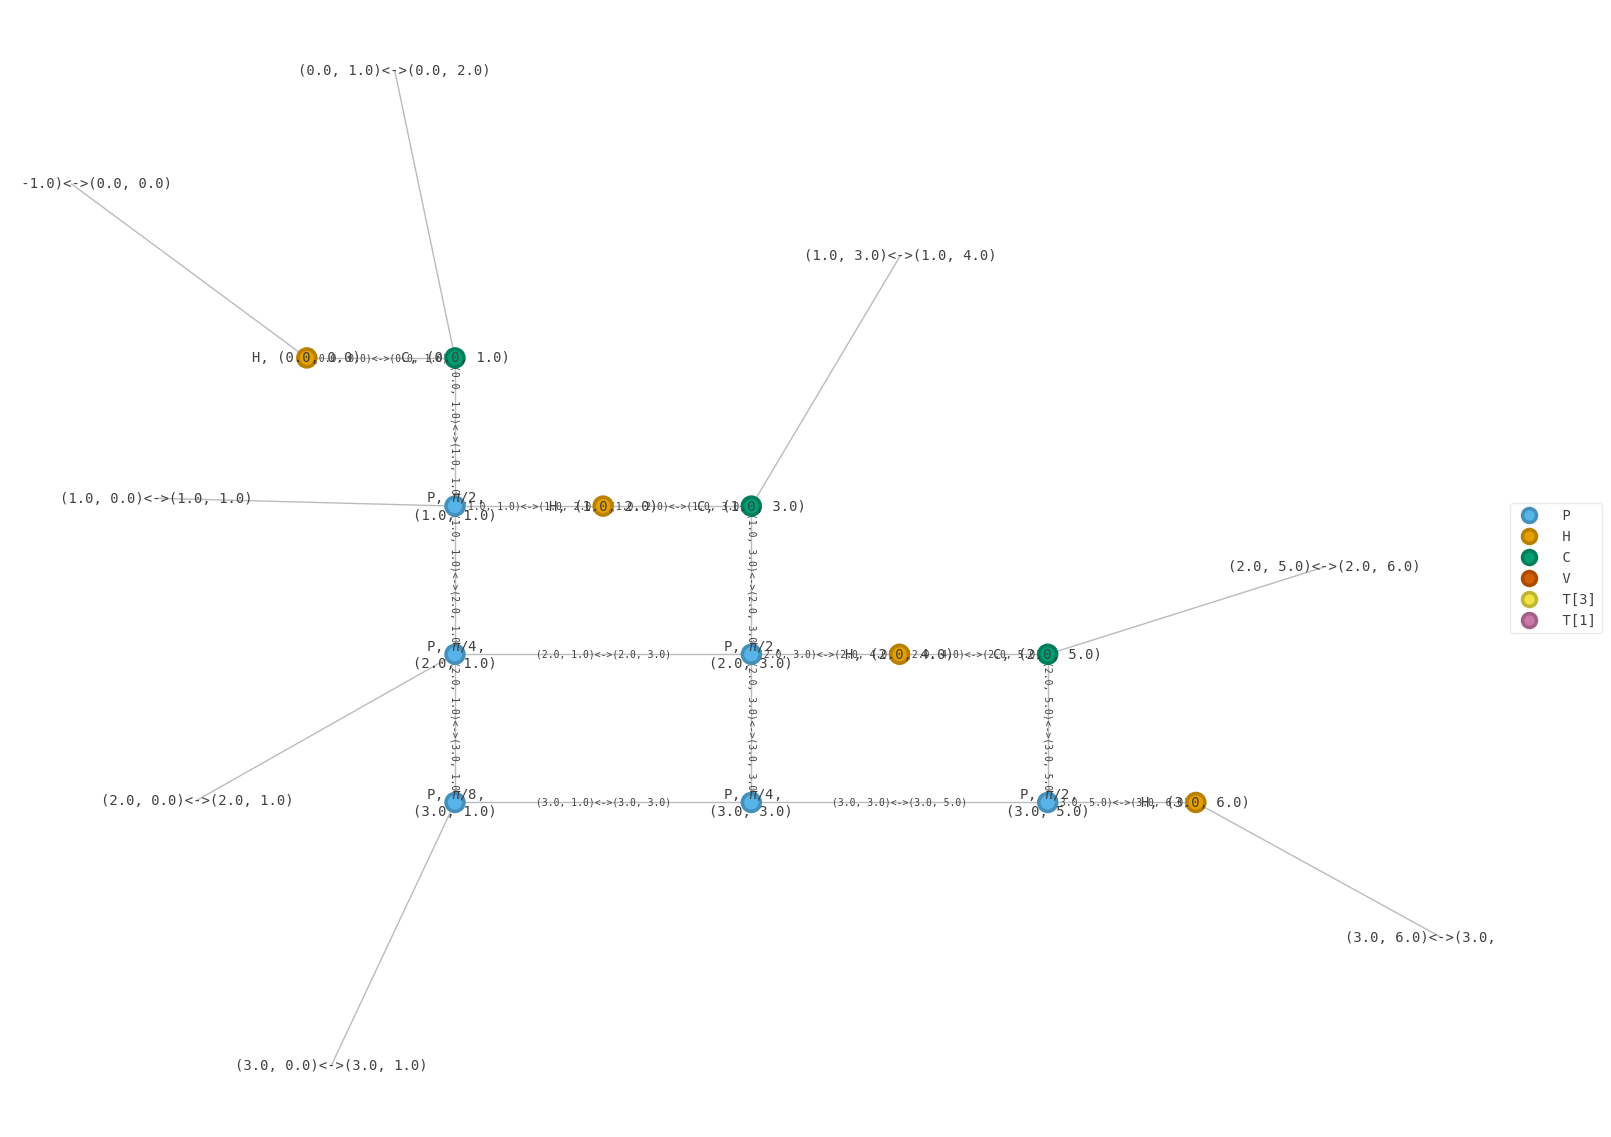

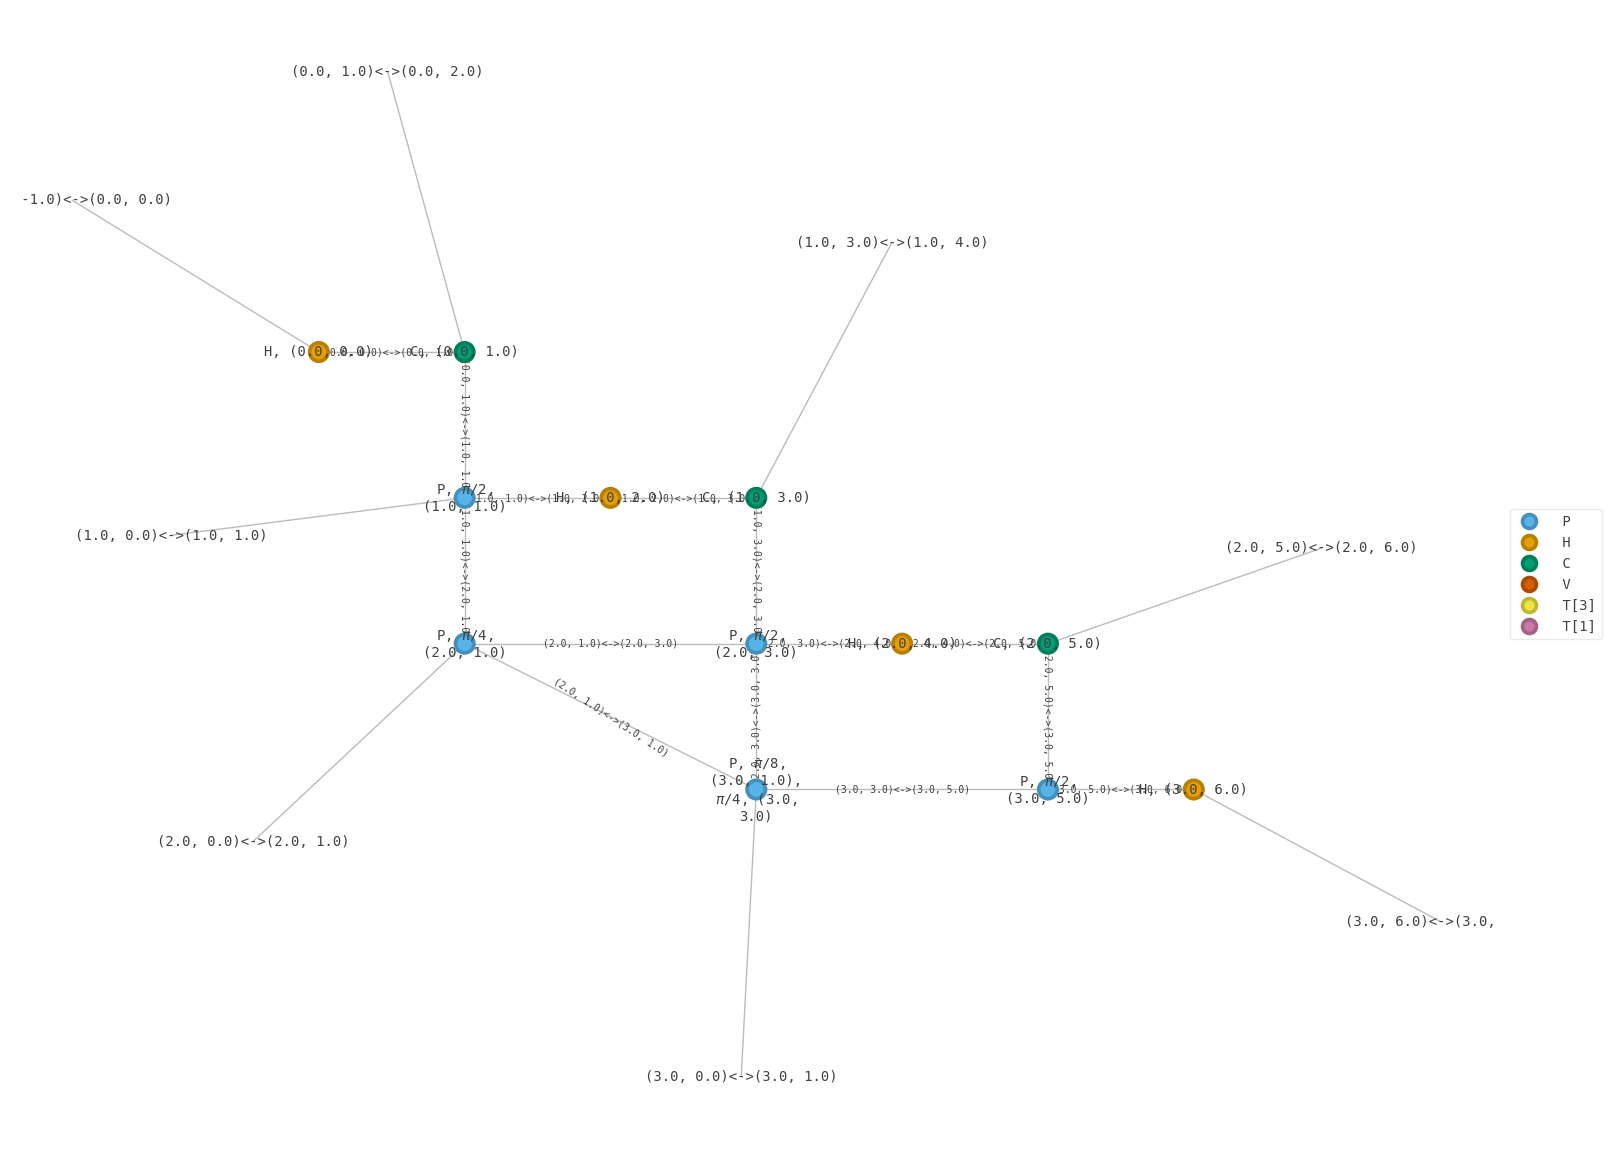

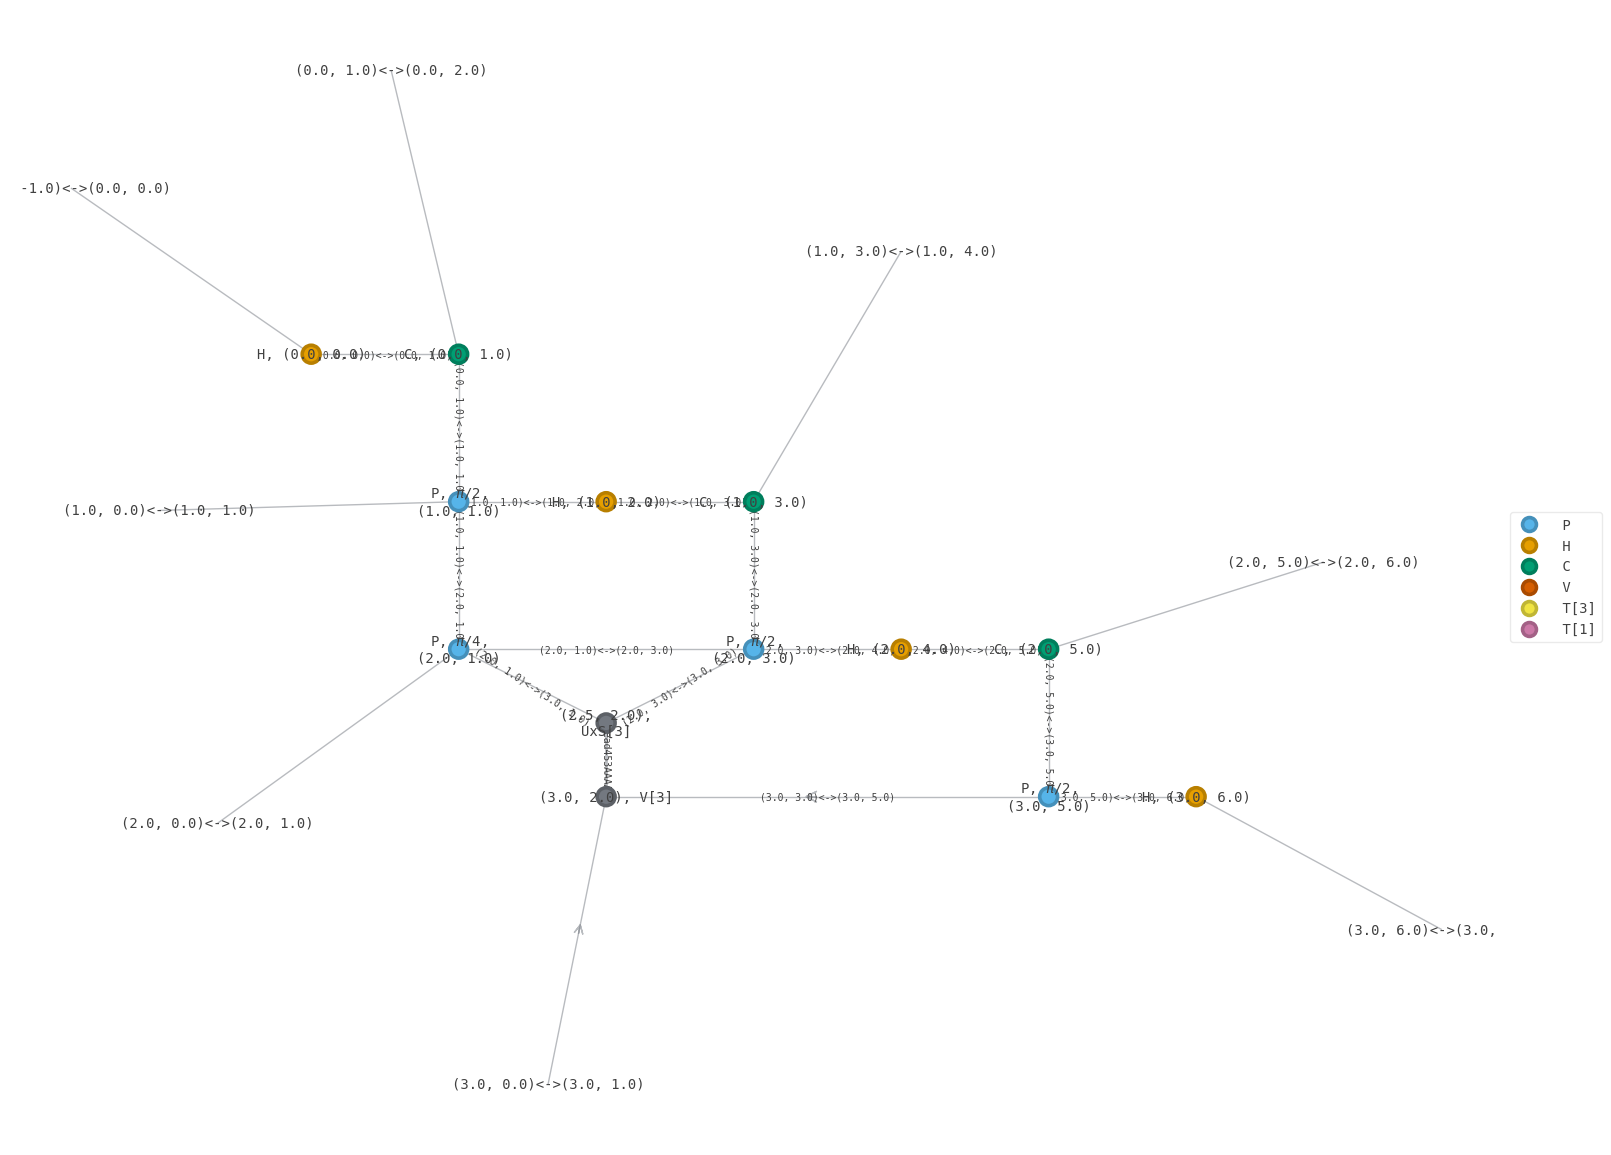

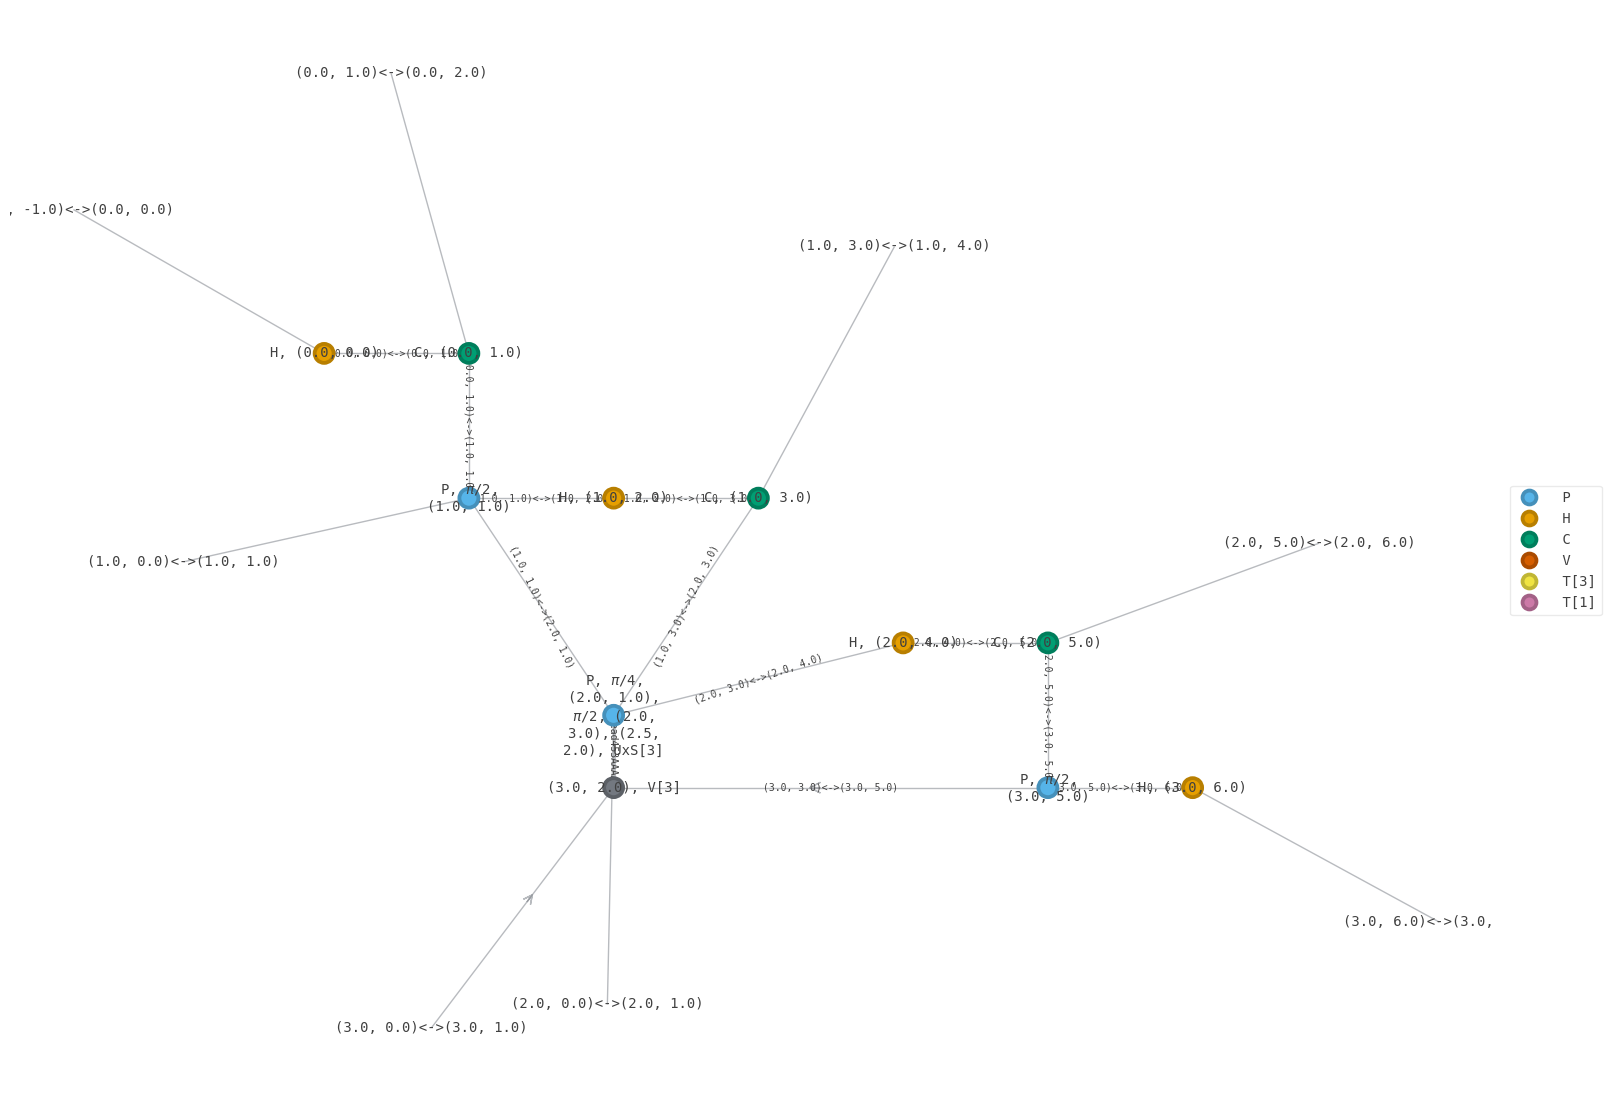

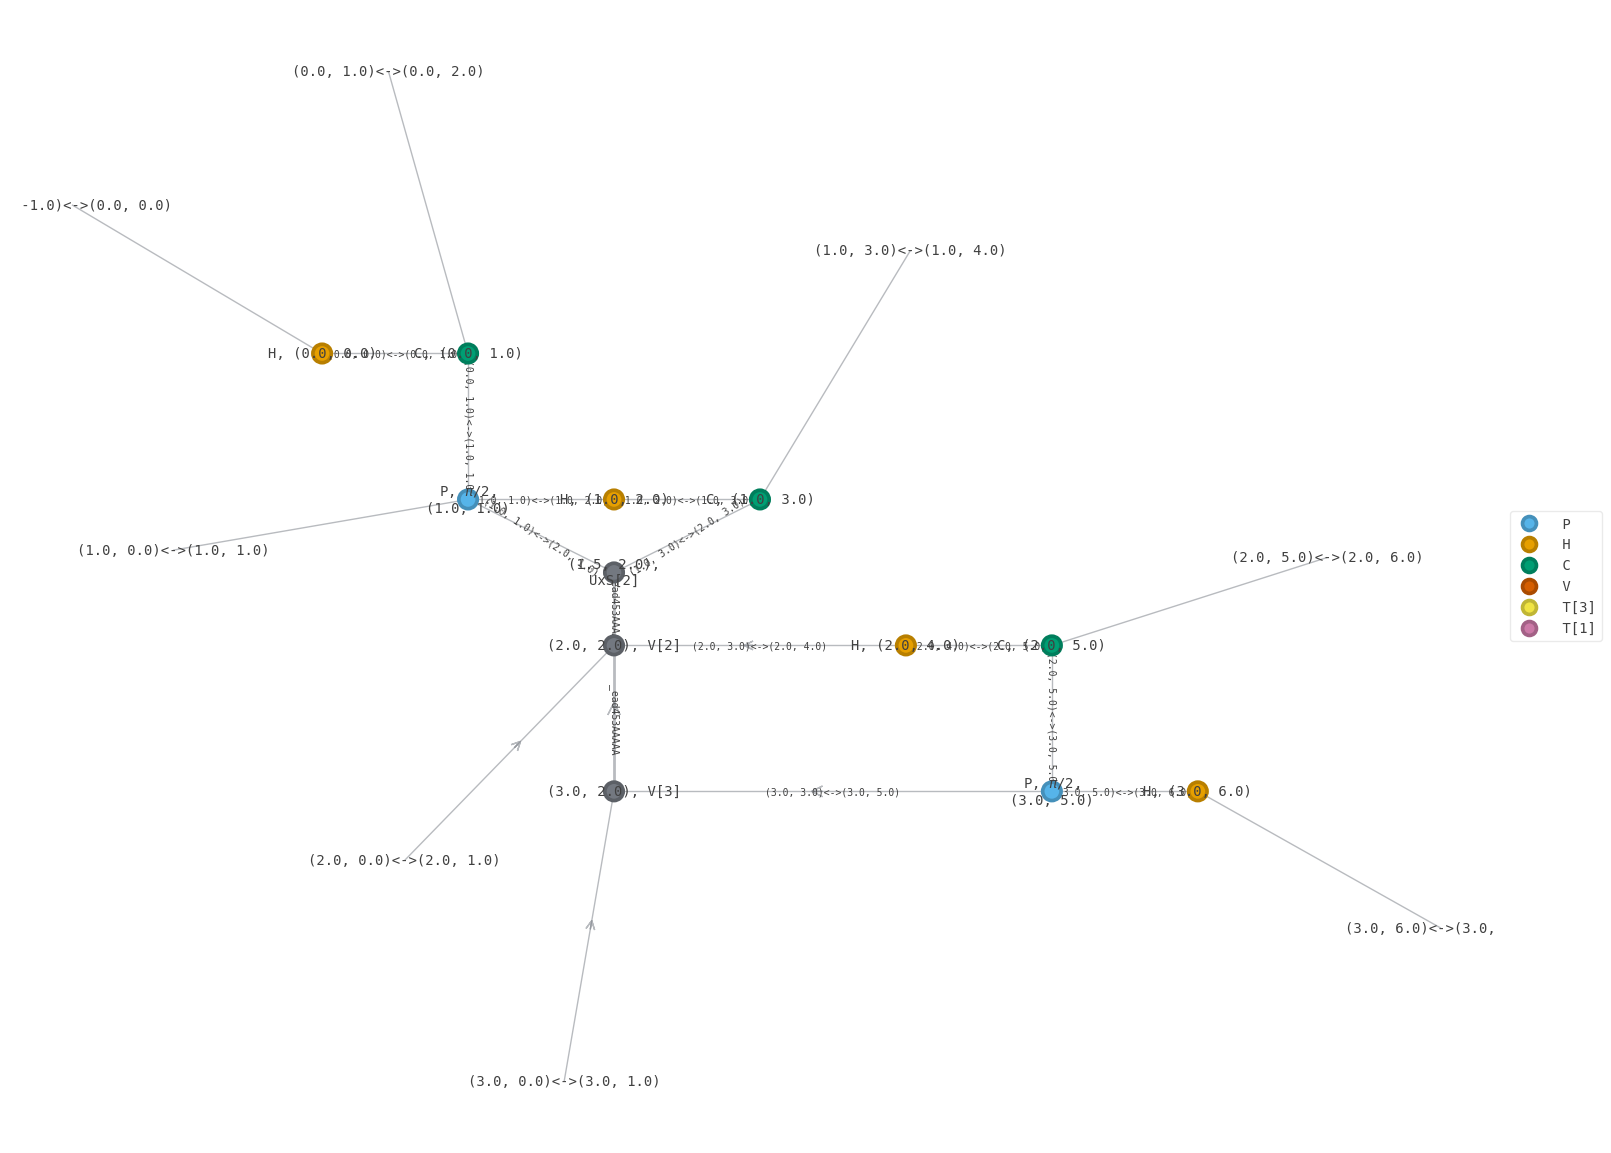

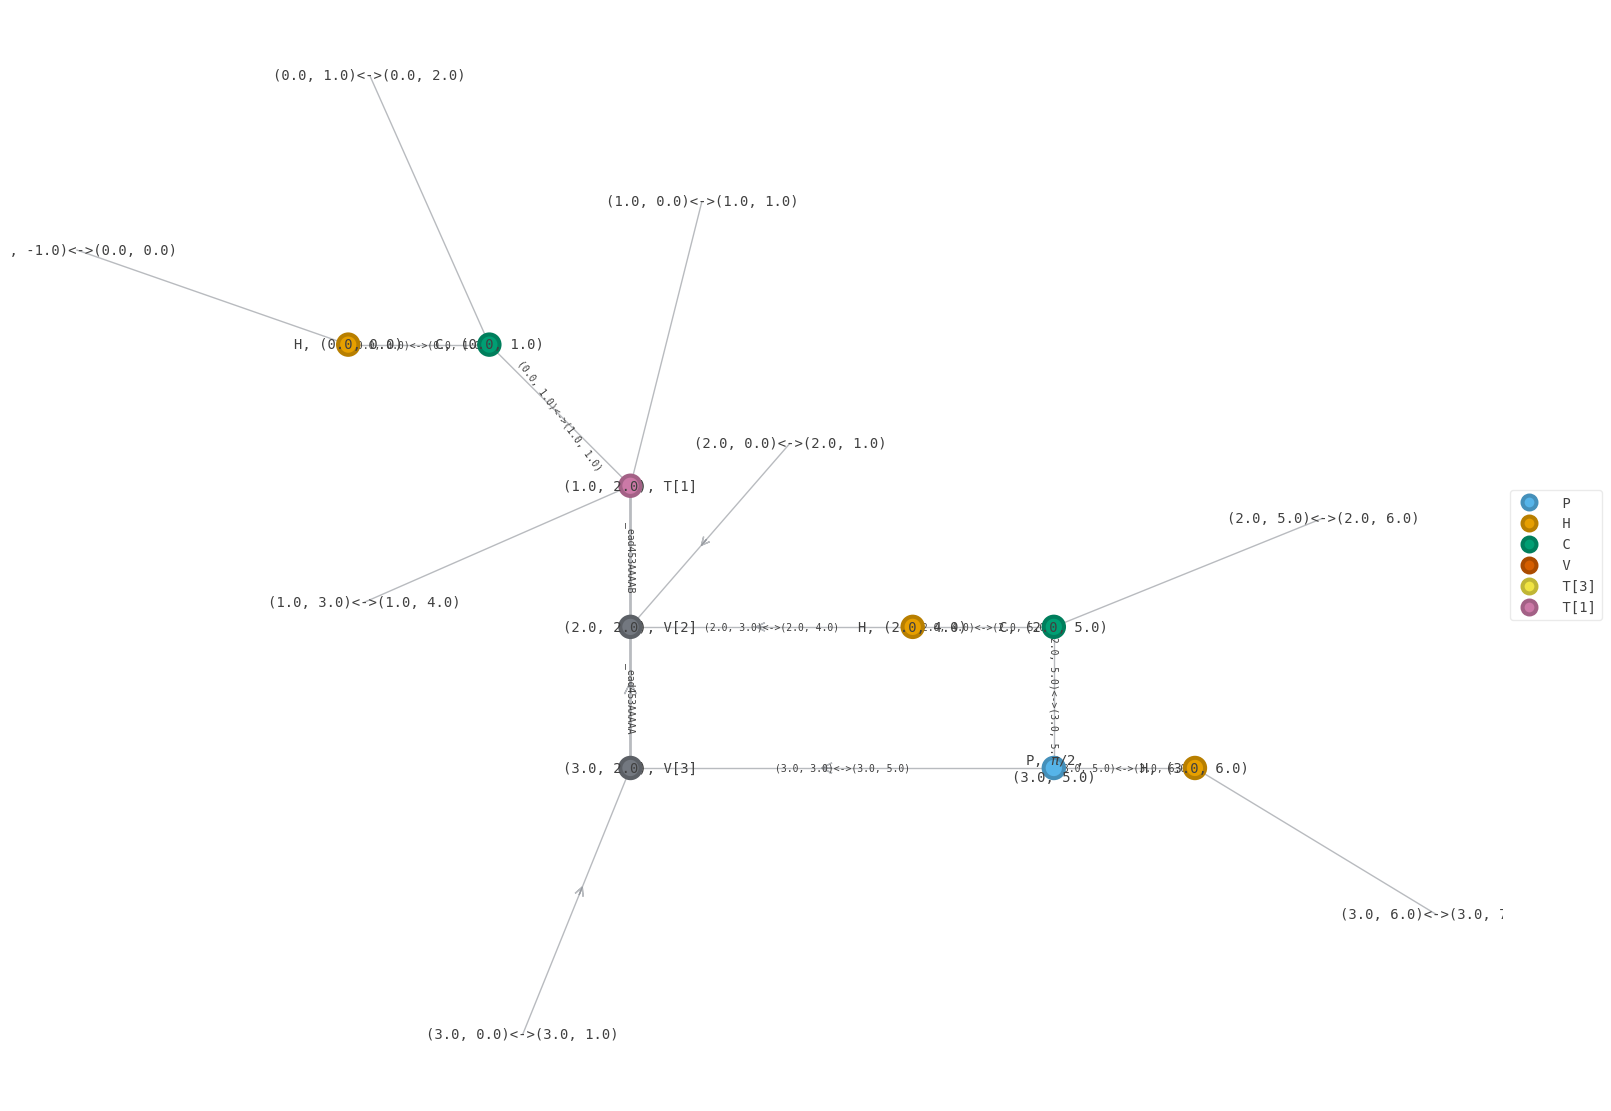

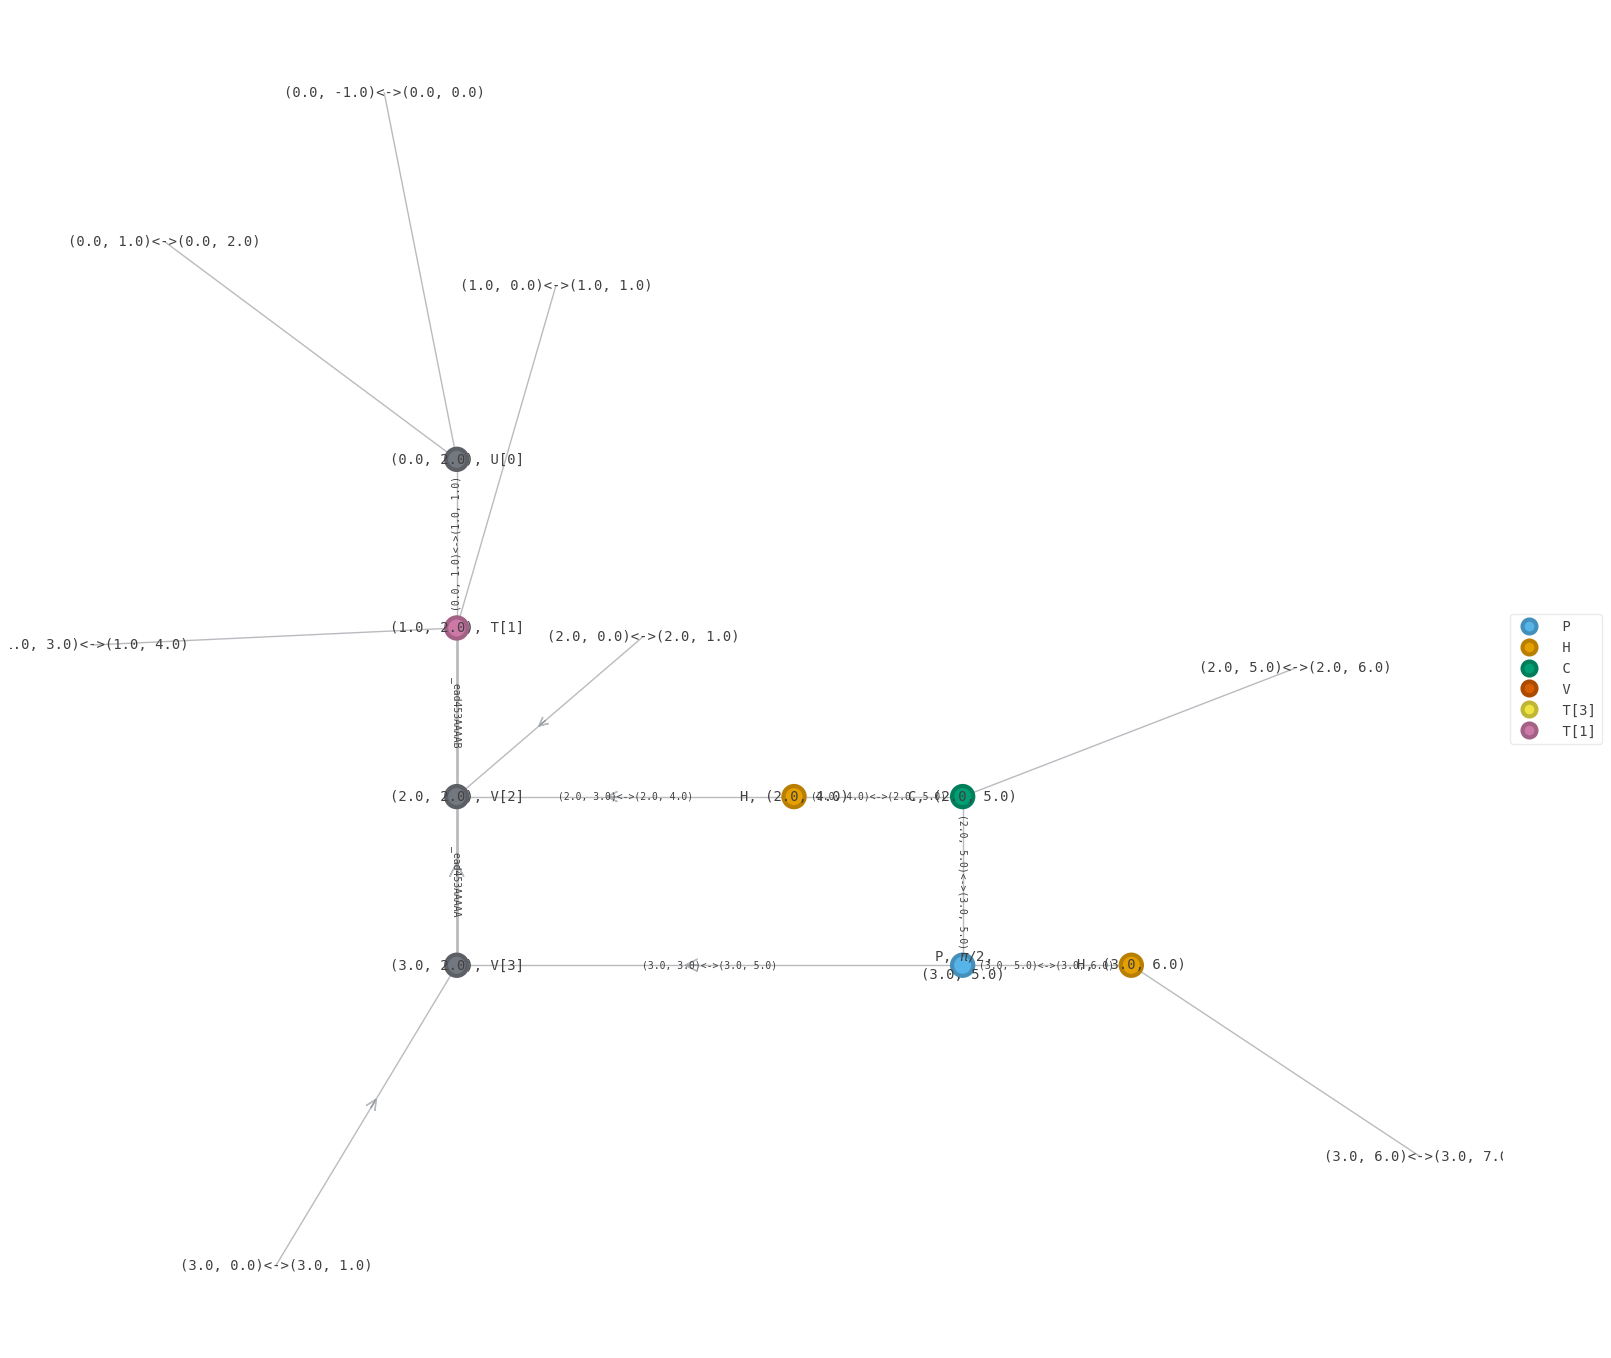

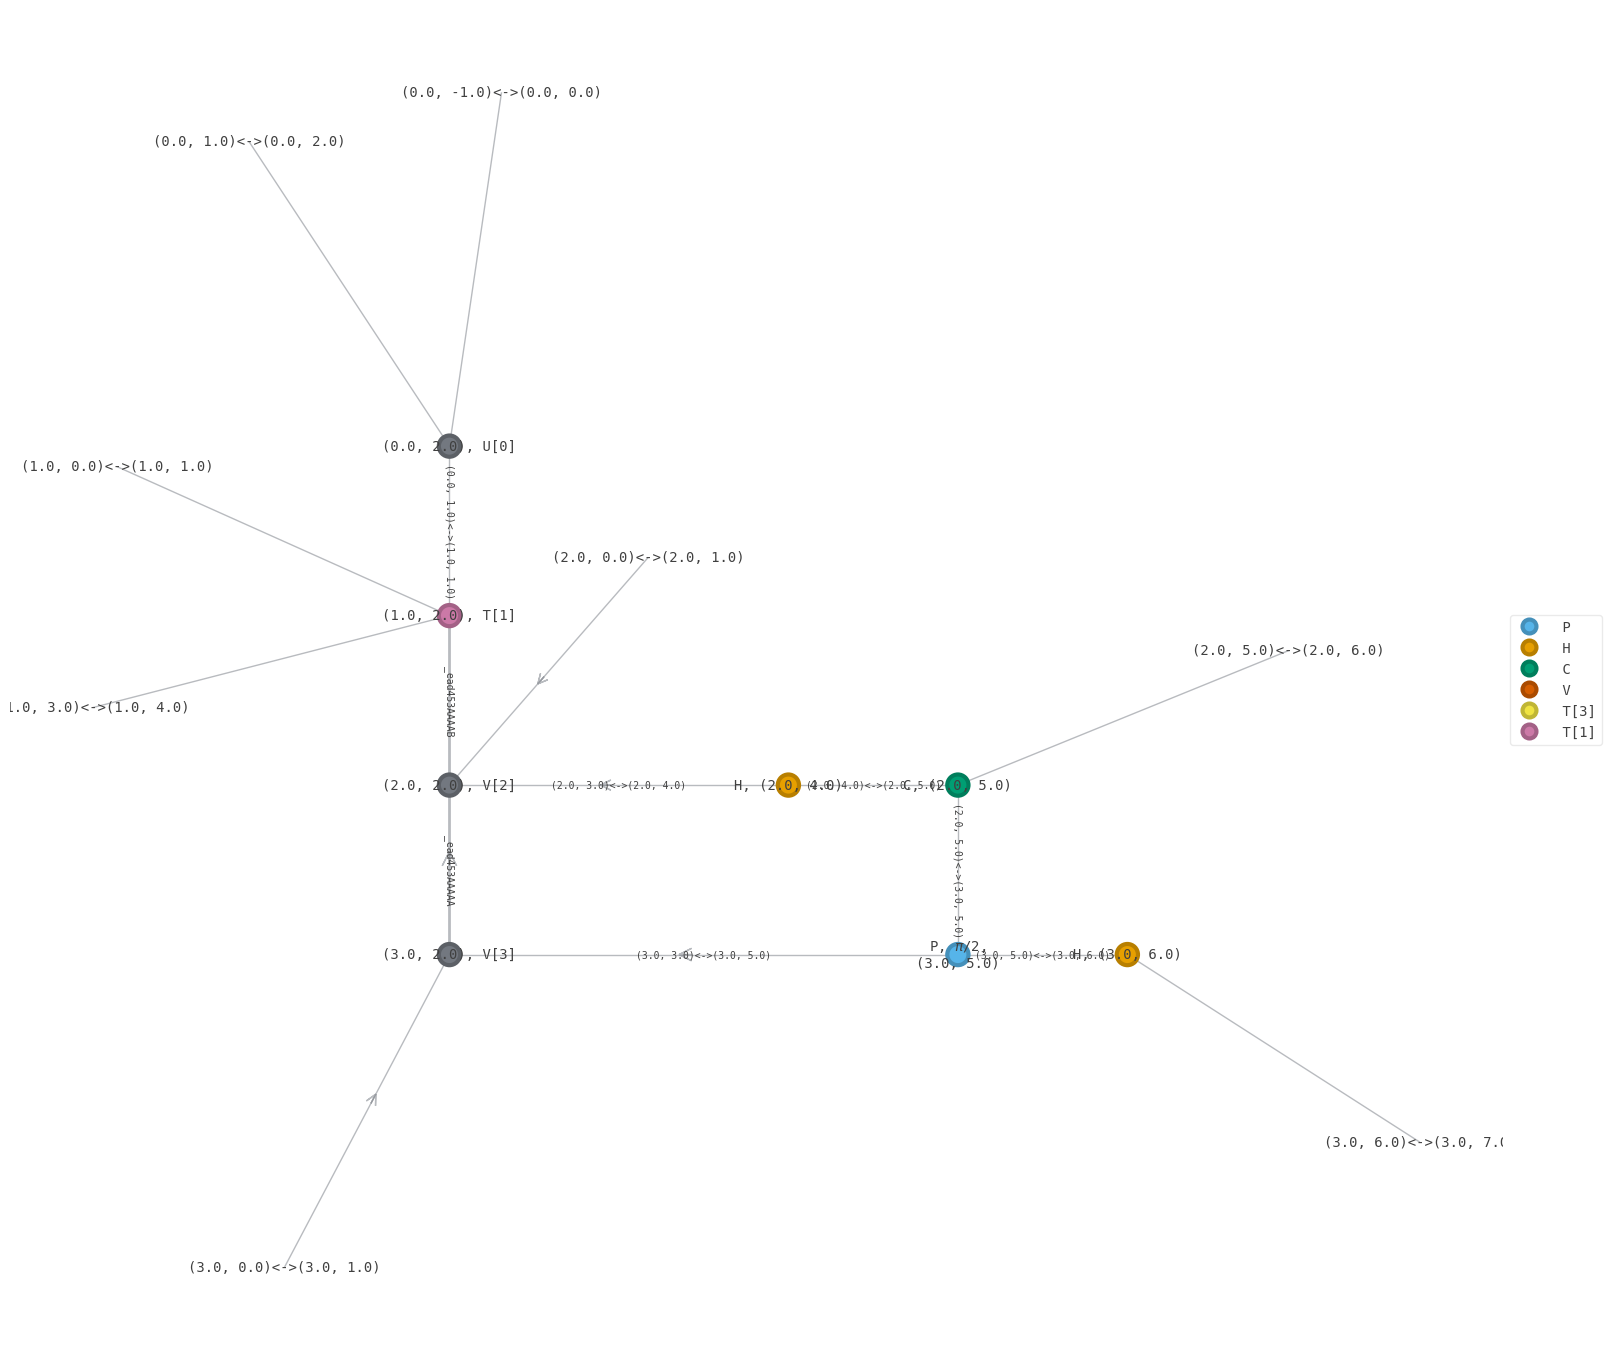

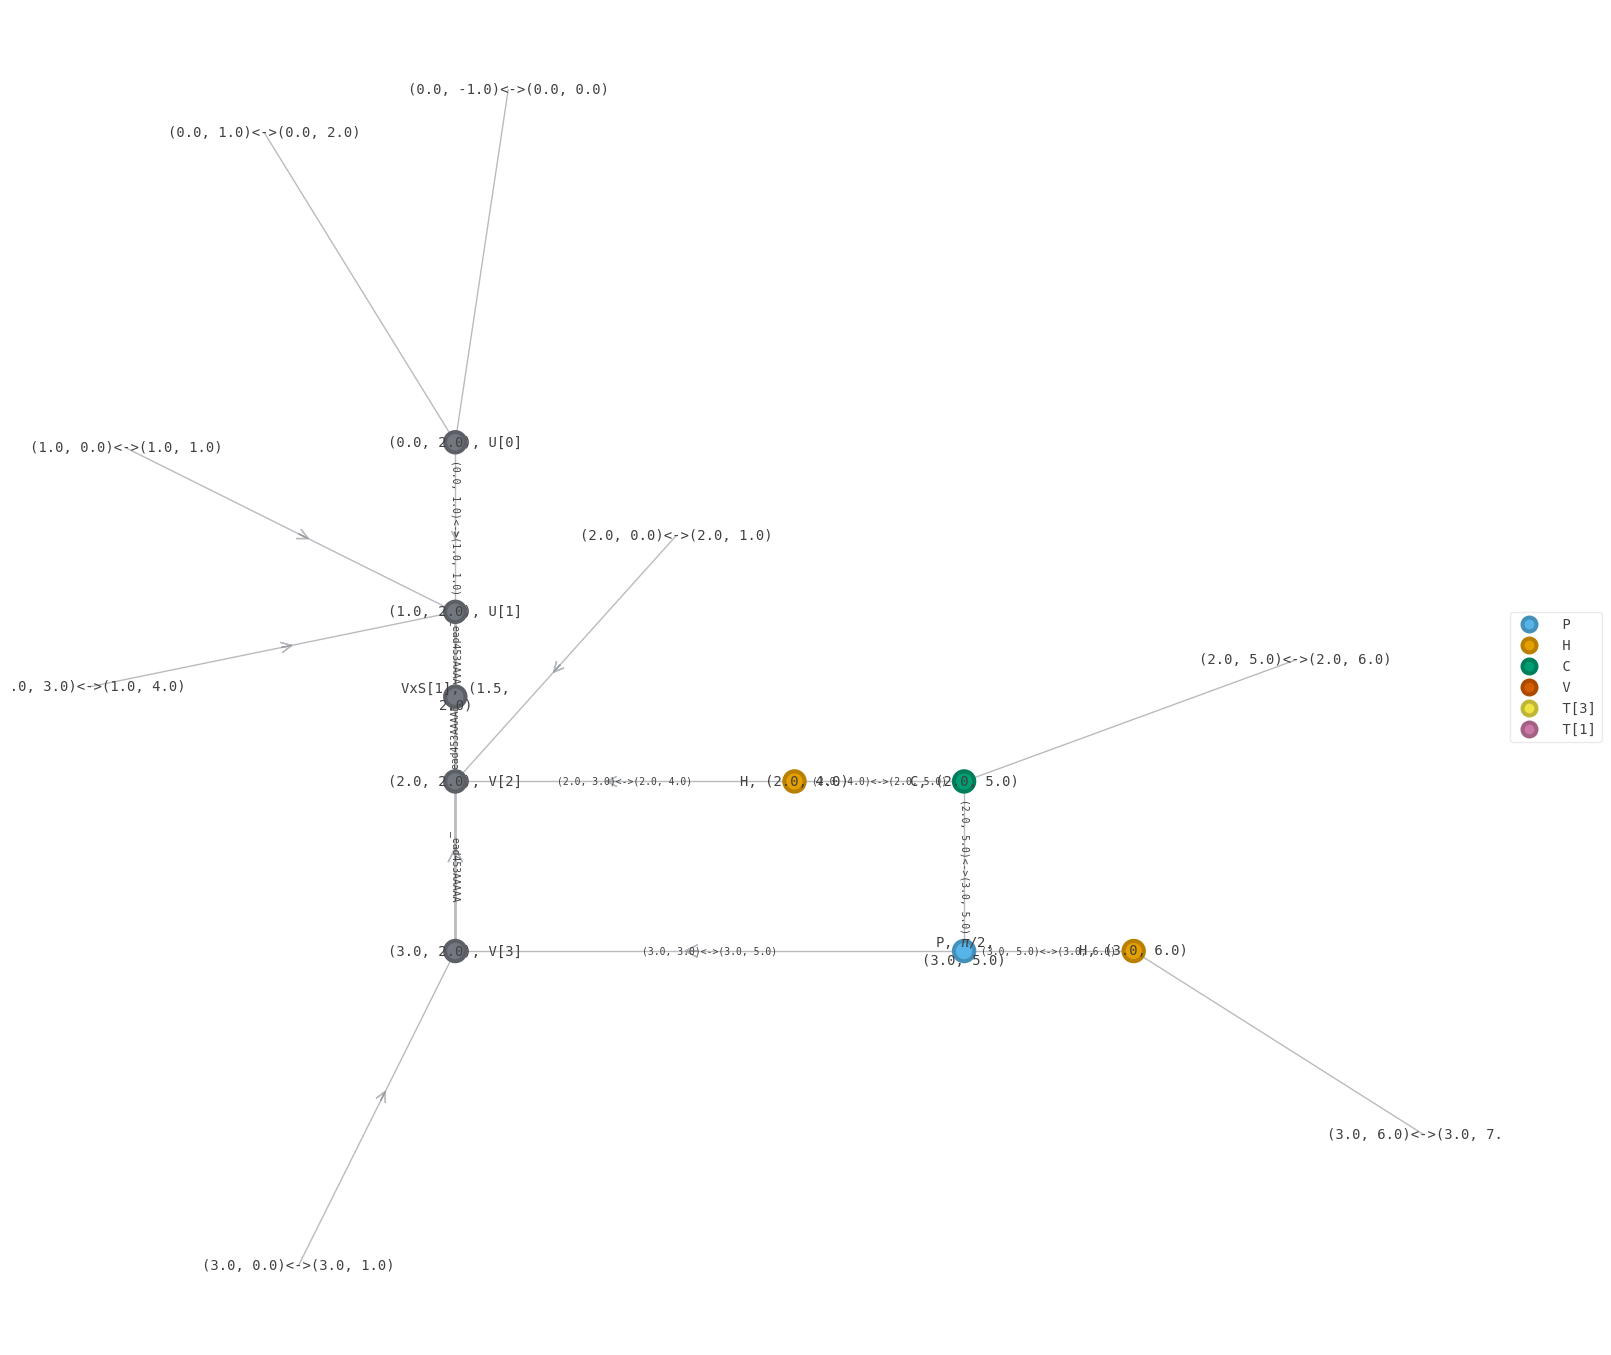

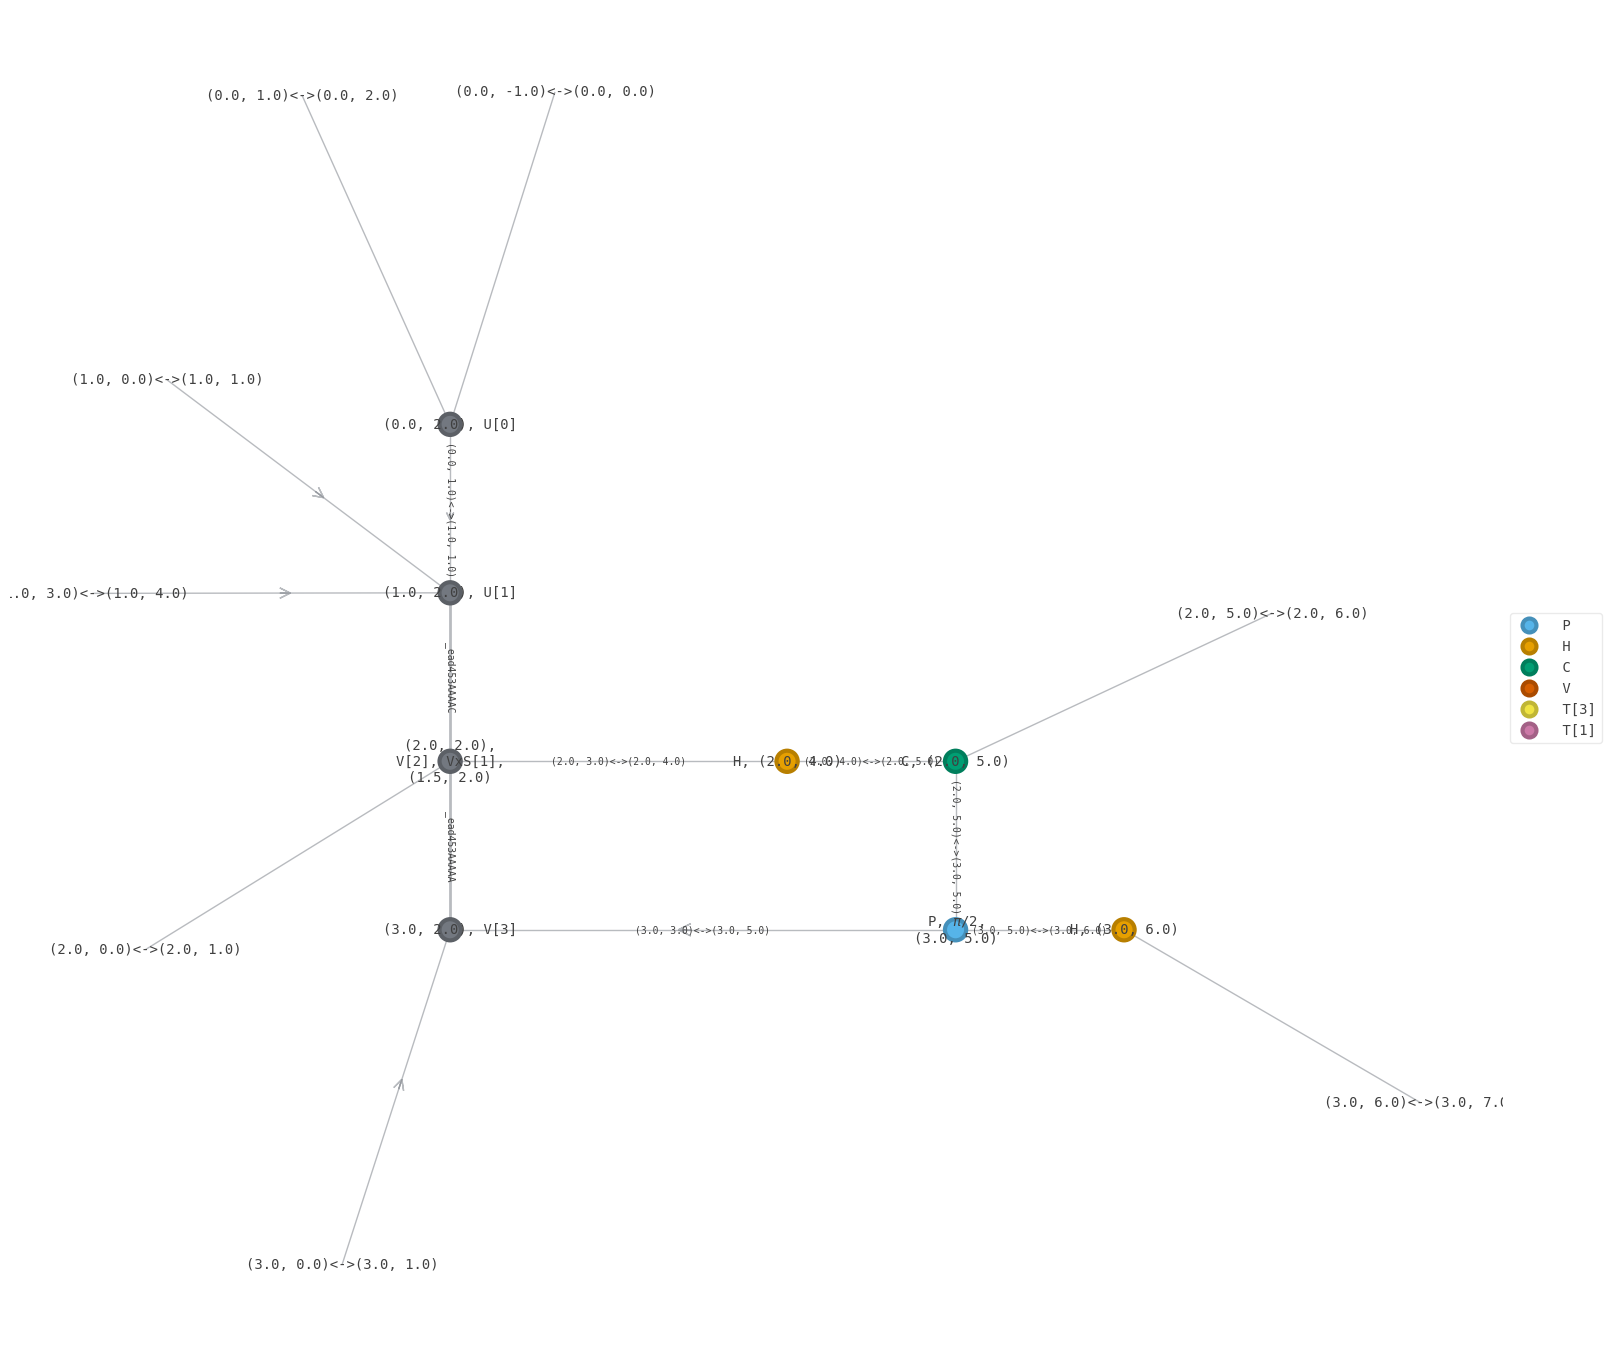

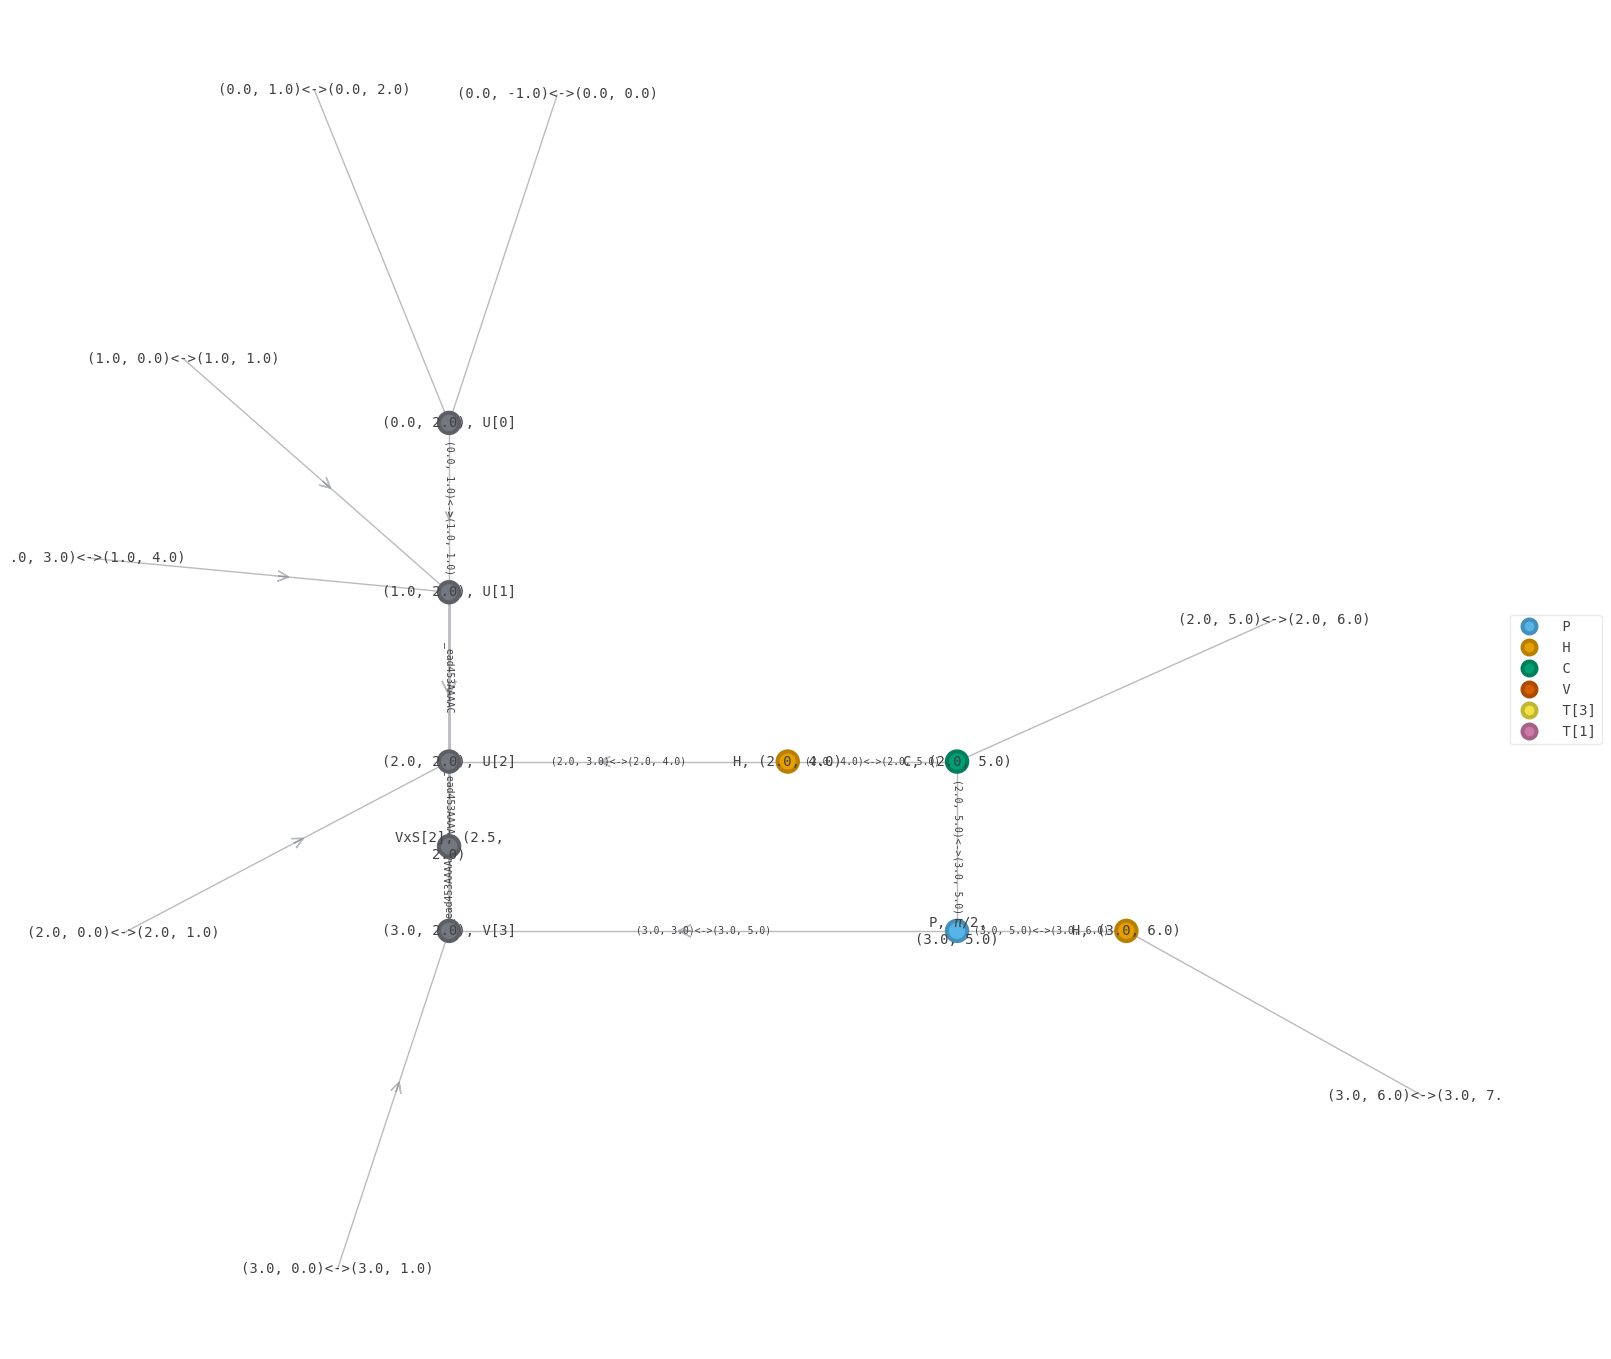

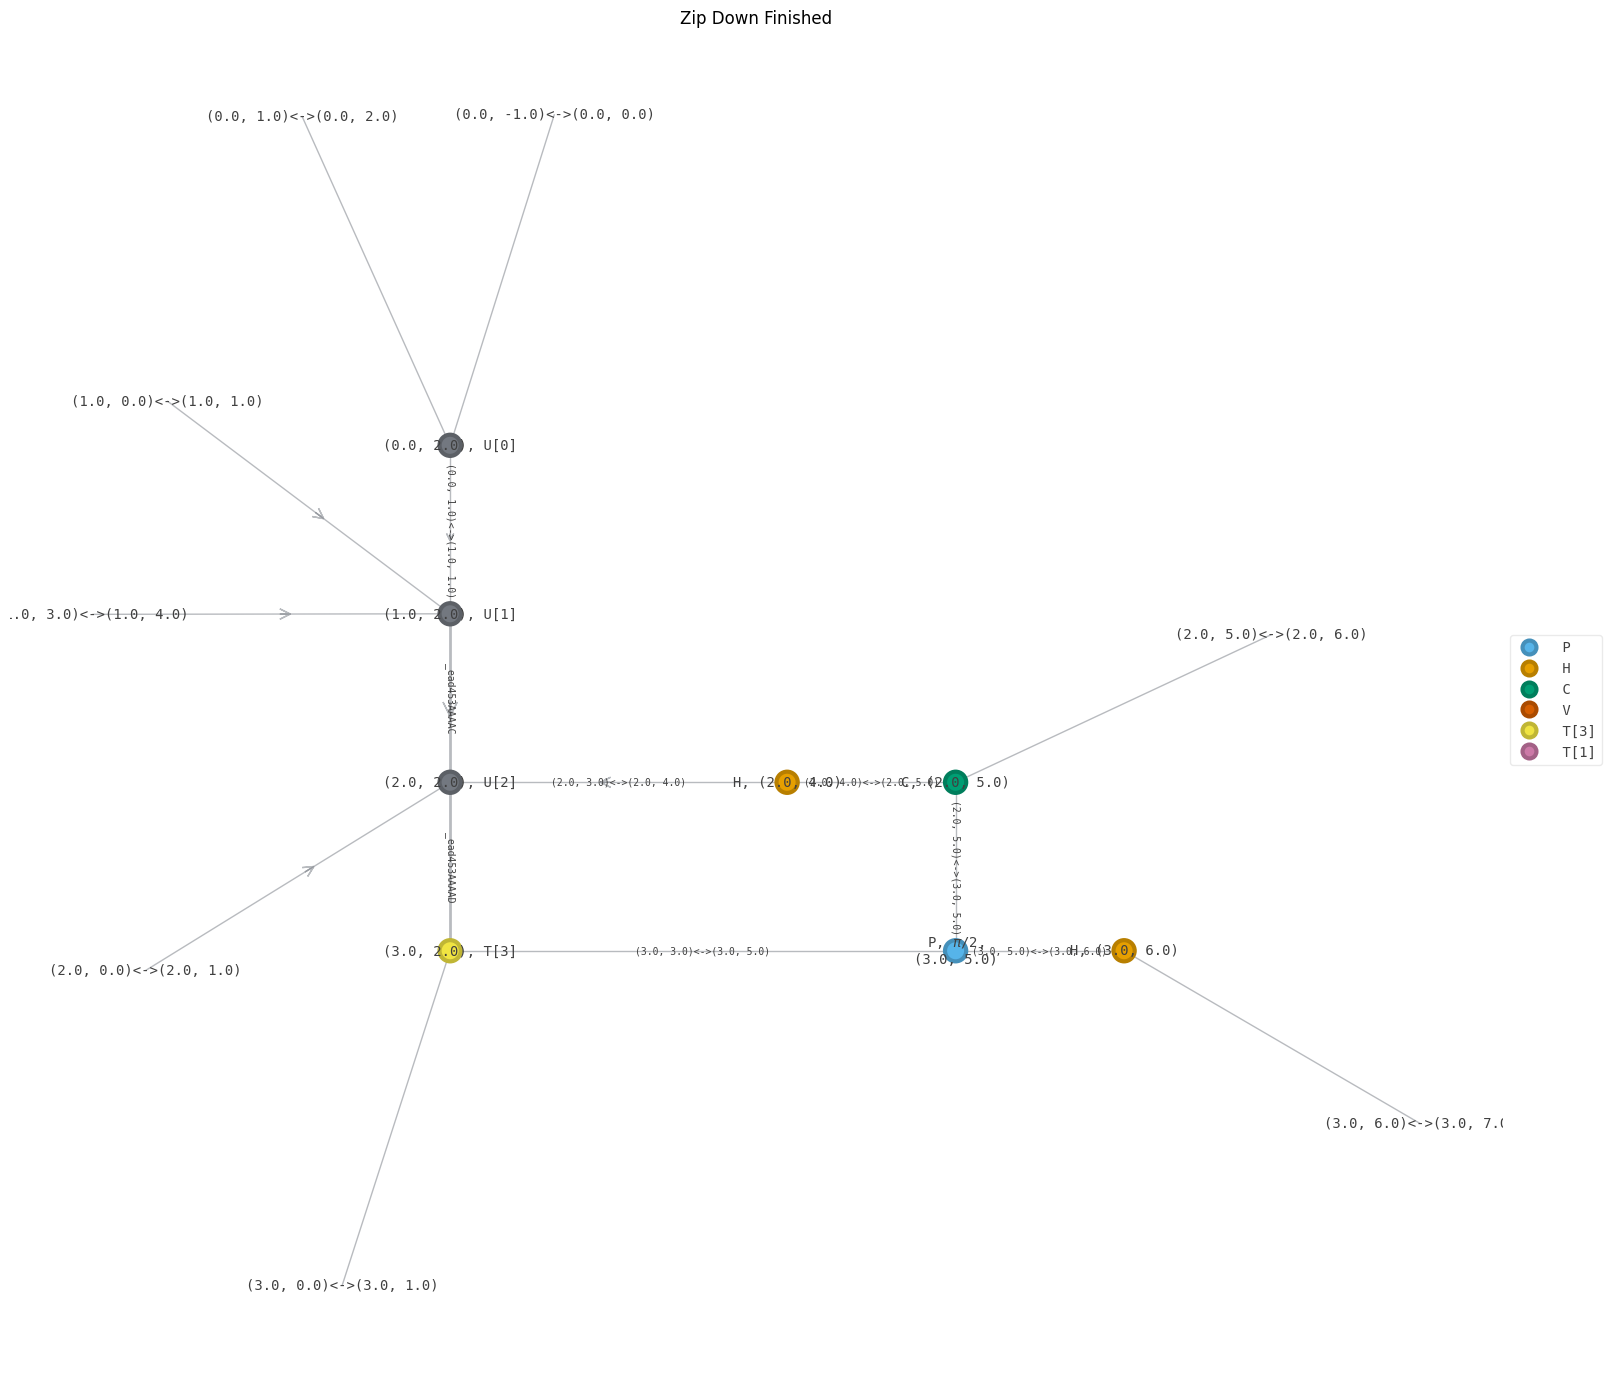

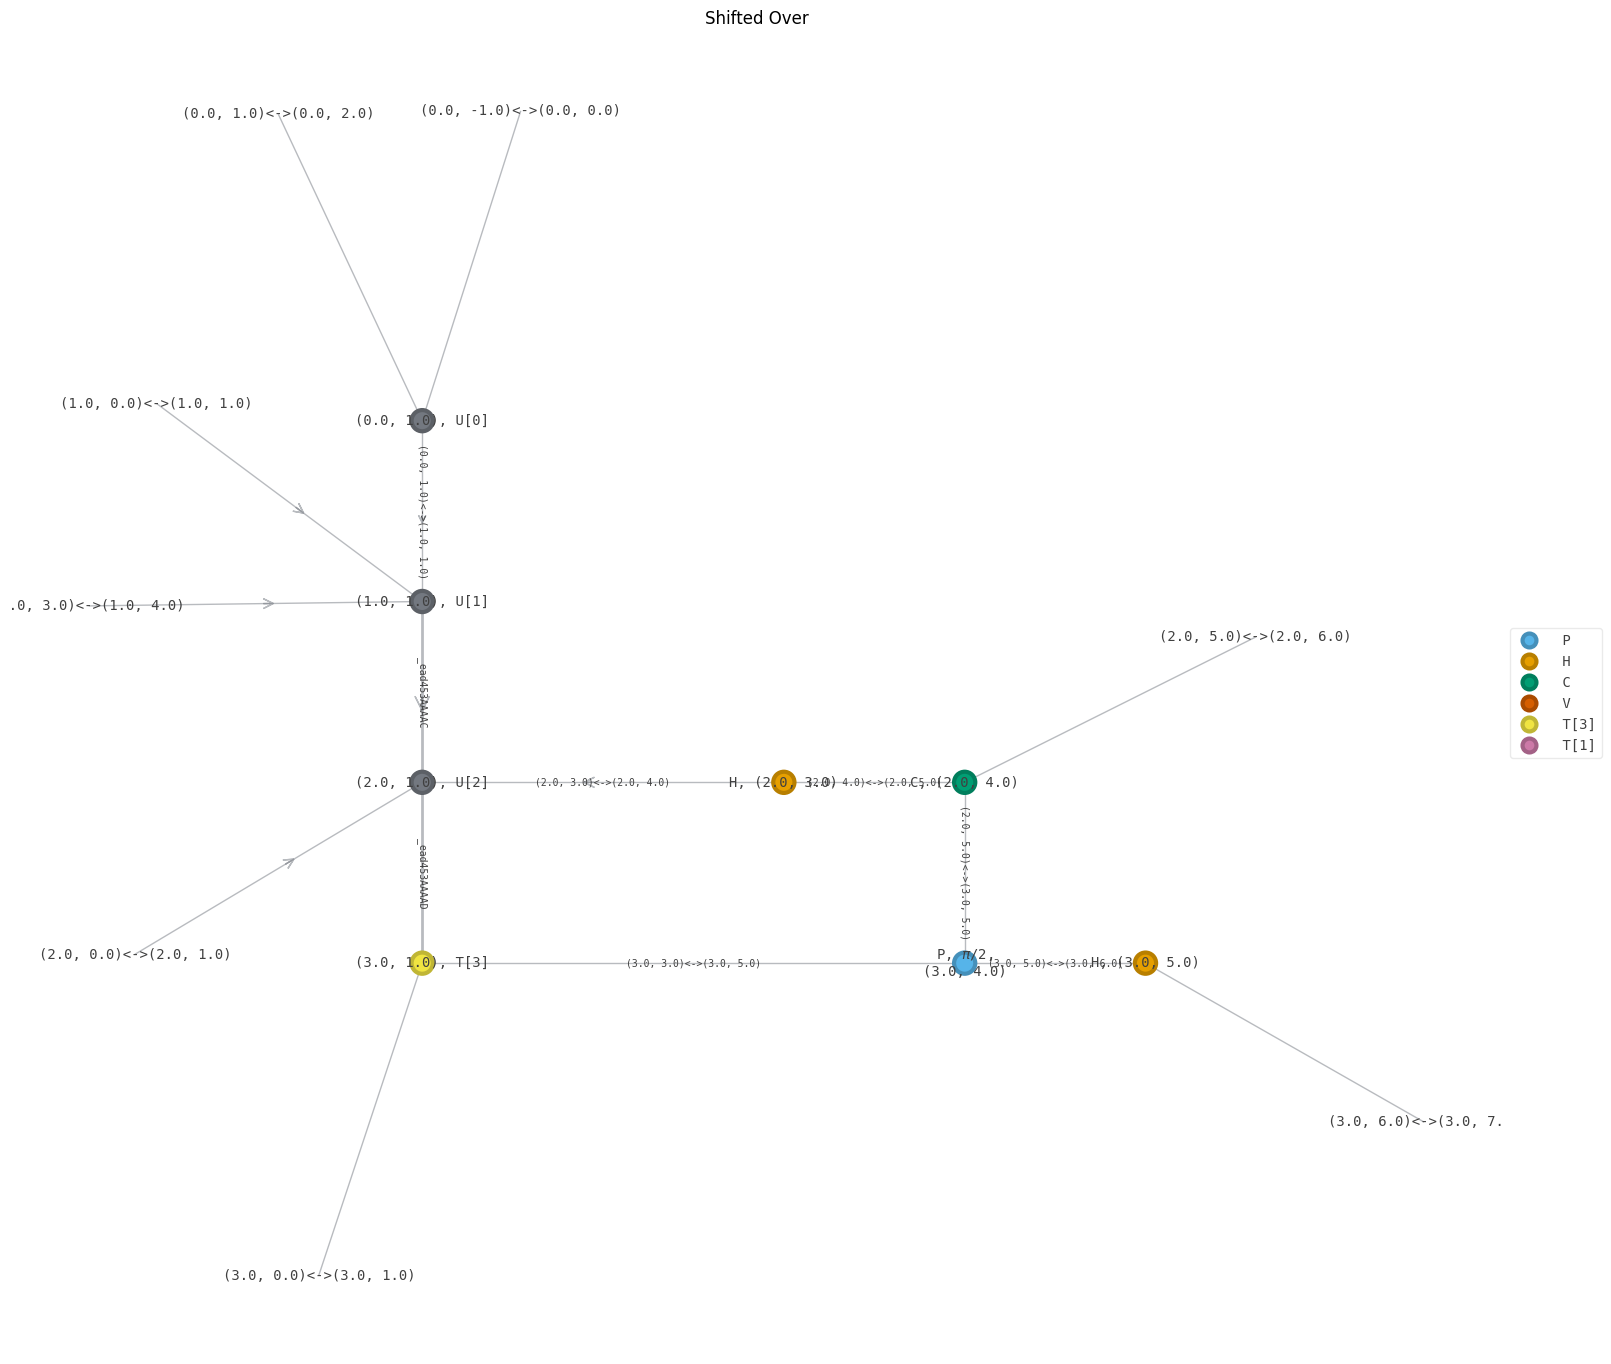

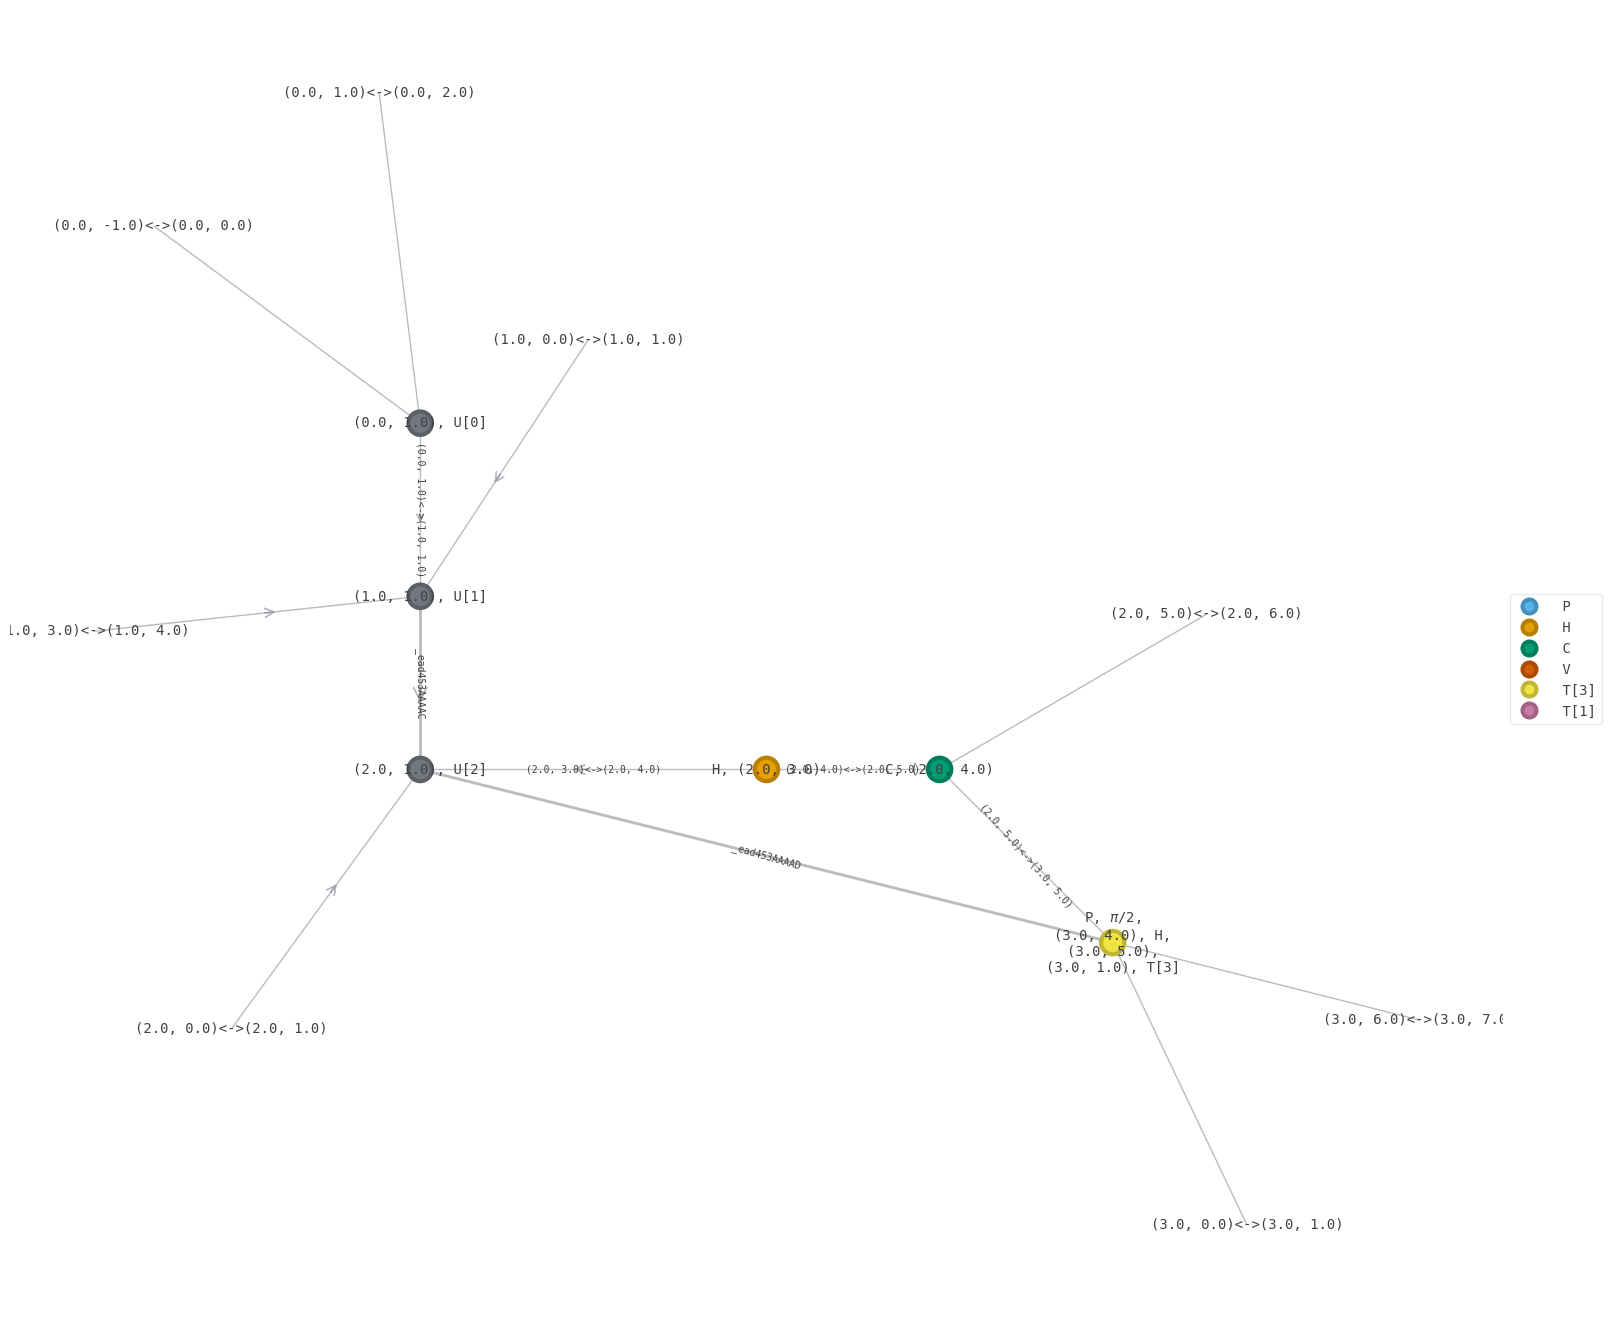

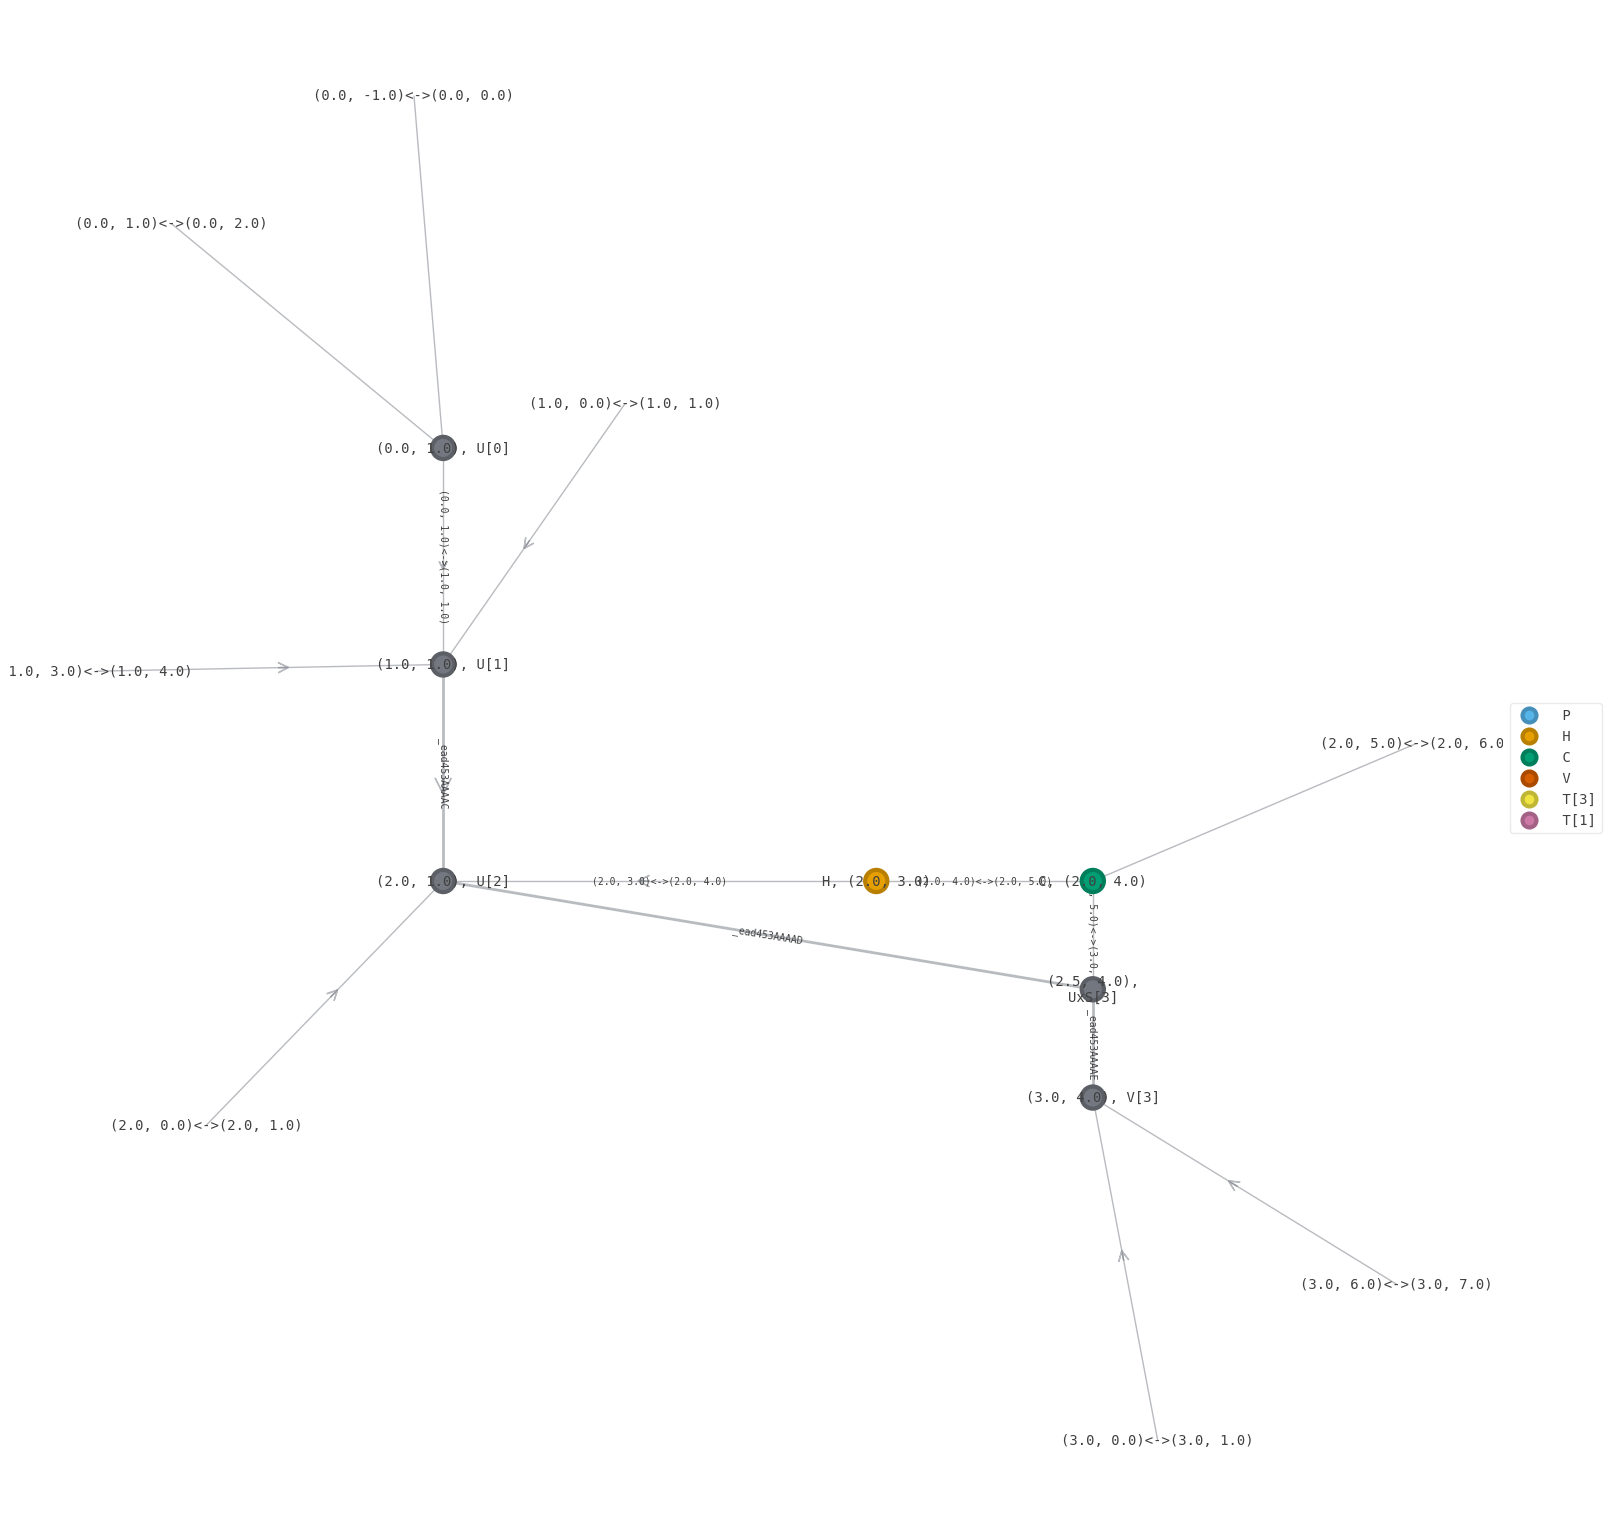

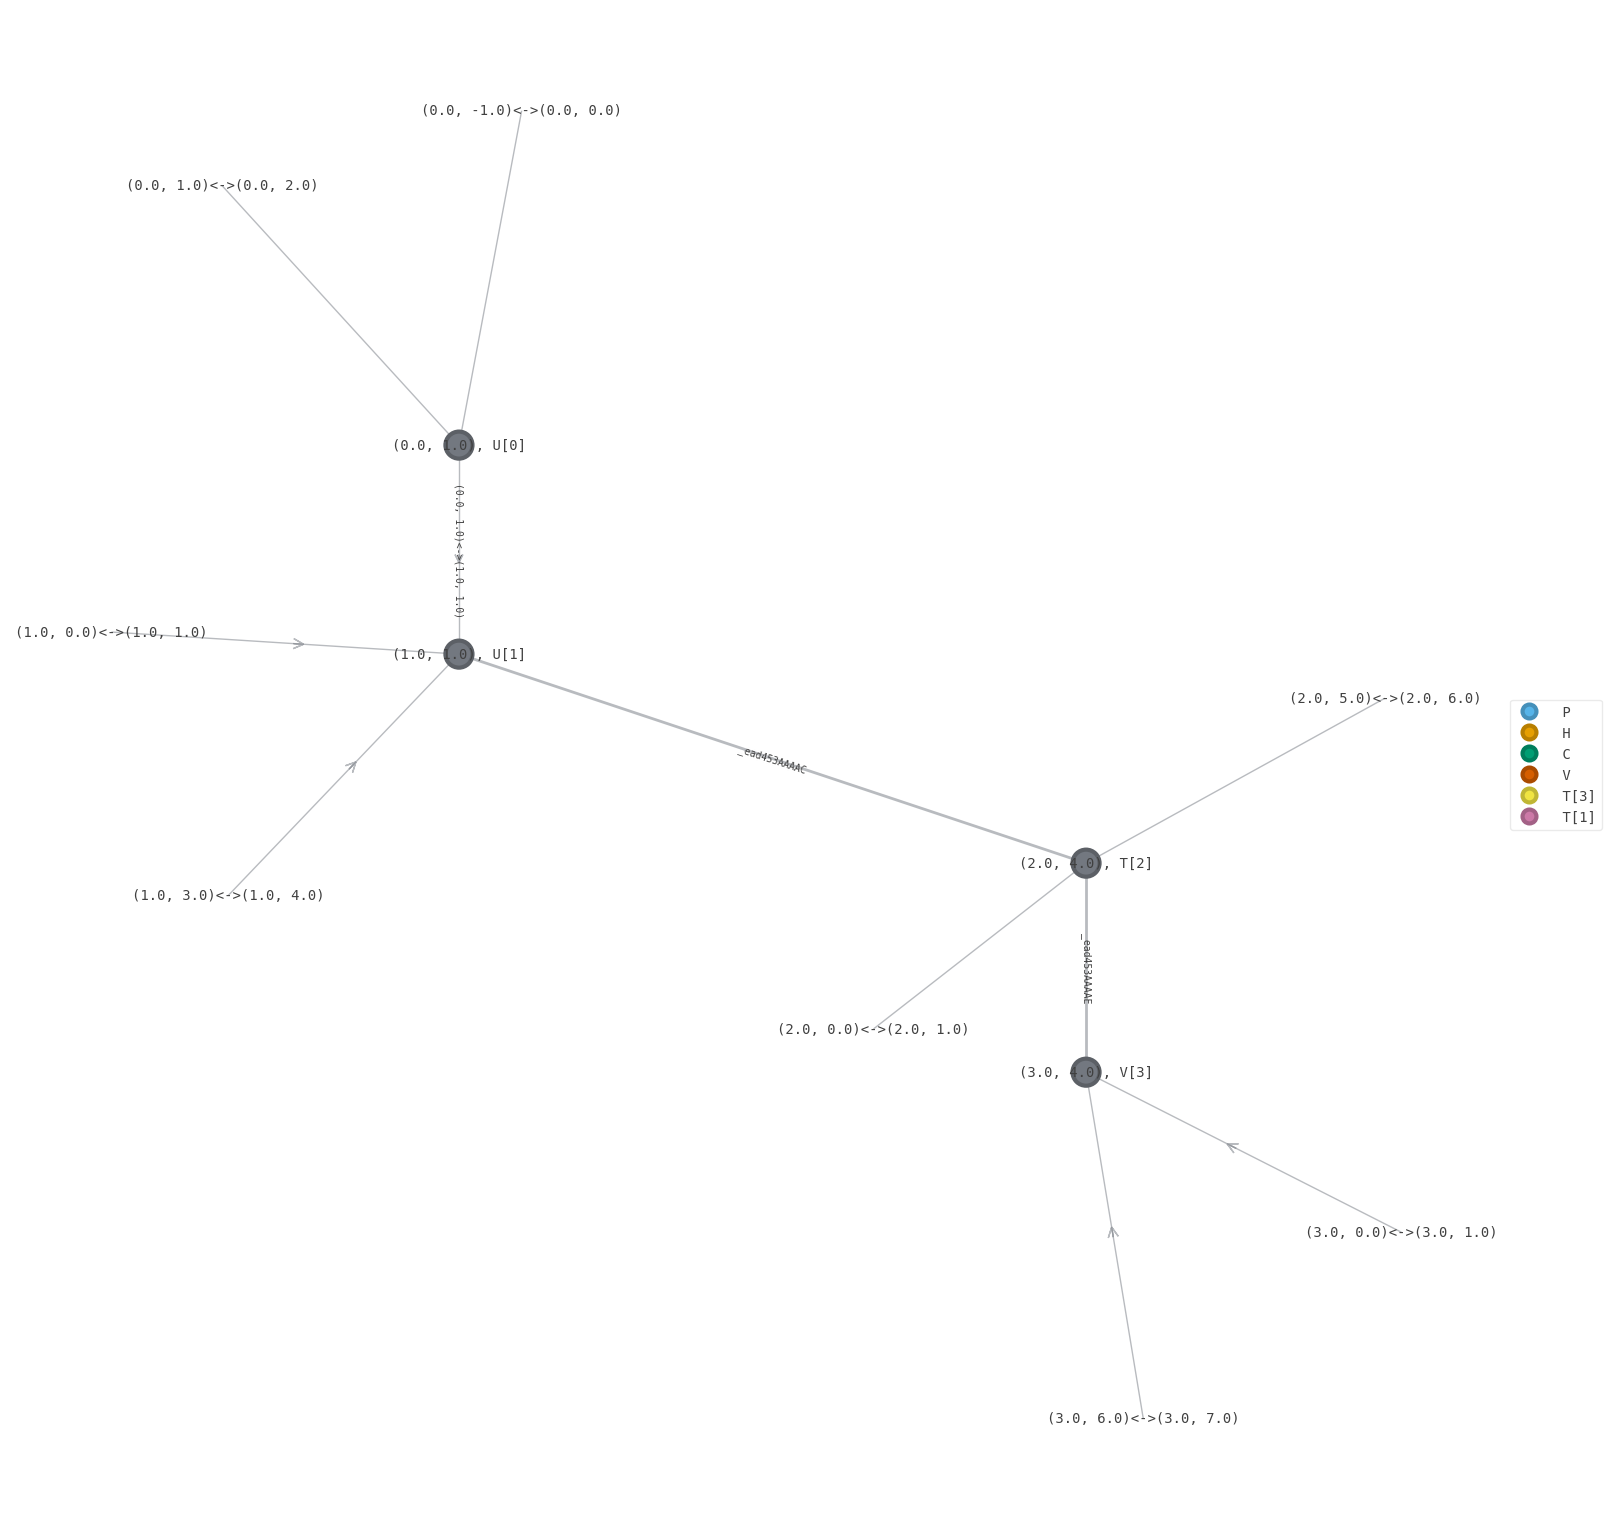

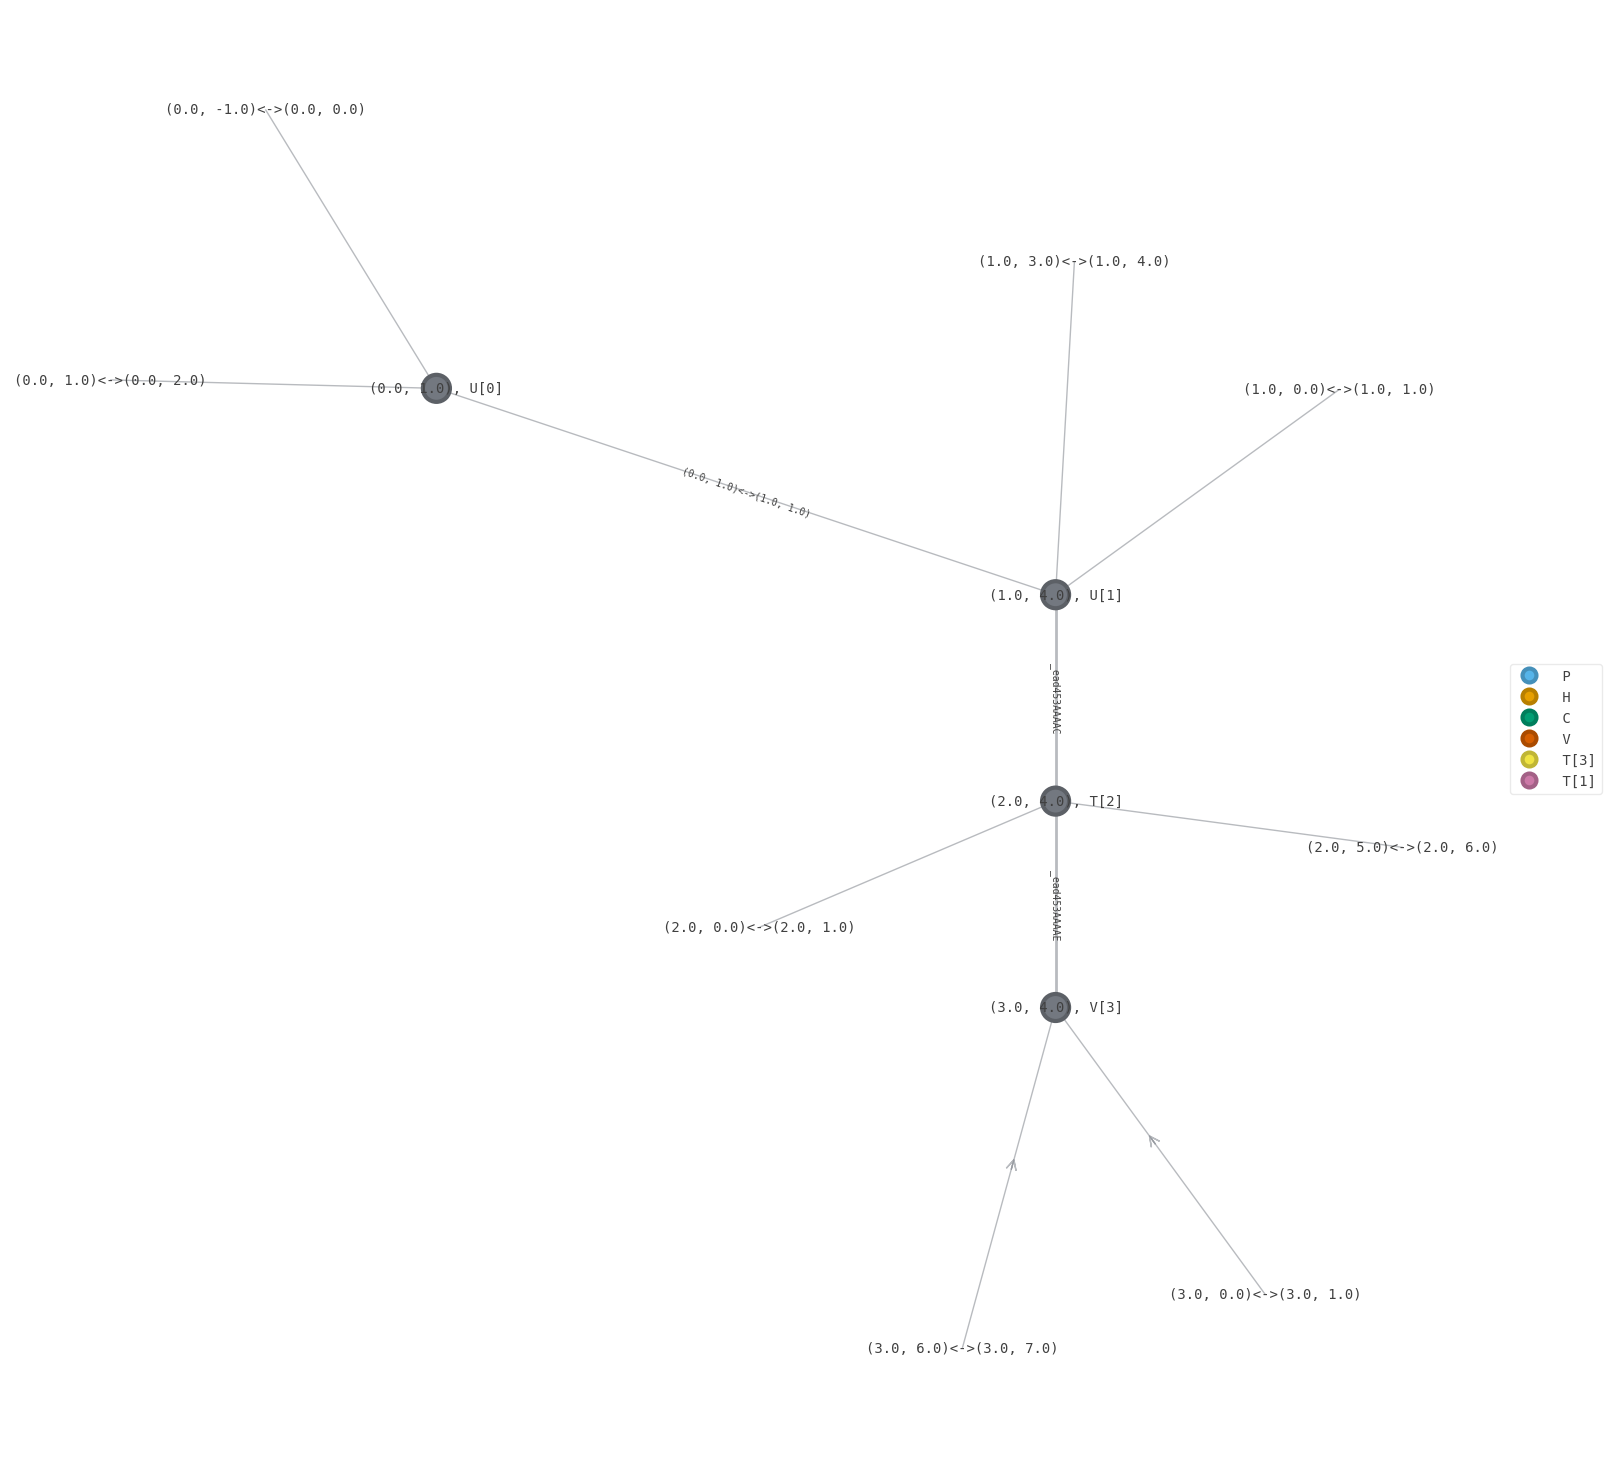

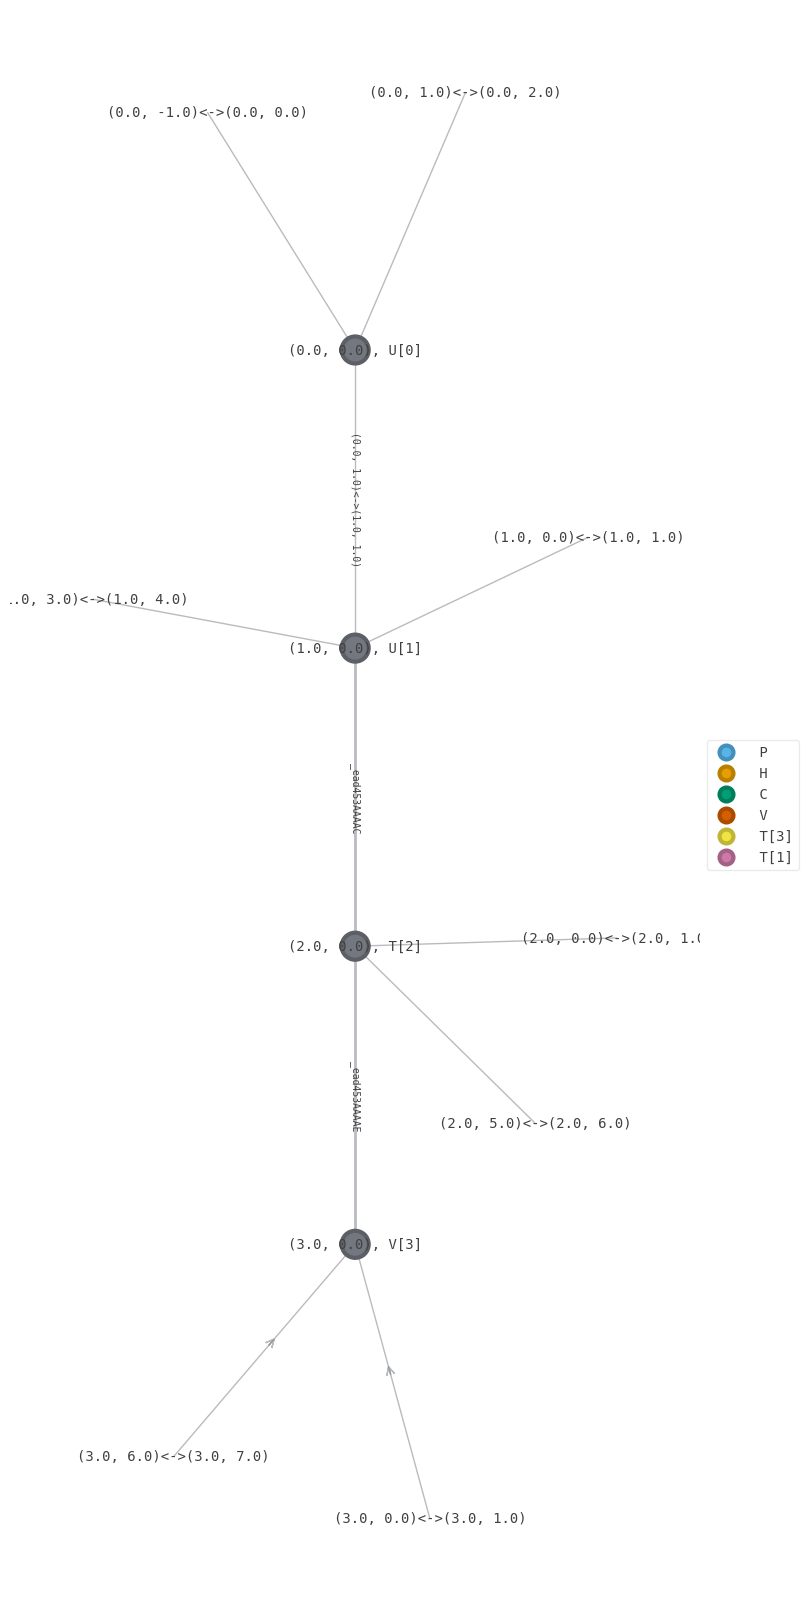

Tensor shape: (2, 2, 2)
Tensor: Tensor(shape=(2, 2, 2), inds=('(0.0, 1.0)<->(1.0, 1.0)', '(0.0, 1.0)<->(0.0, 2.0)', '(0.0, -1.0)<->(0.0, 0.0)'), tags=oset(['(0.0, 0.0)', 'U[0]']), backend='numpy', dtype='complex128')
Tensor Data:
 [[[ 0.70710678+0.j  0.        +0.j]
  [ 0.        +0.j  0.70710678+0.j]]

 [[ 0.70710678+0.j  0.        +0.j]
  [ 0.        +0.j -0.70710678+0.j]]]
Tensor shape: (2, 2, 2, 4)
Tensor: Tensor(shape=(2, 2, 2, 4), inds=('_ead453AAAAC', '(1.0, 3.0)<->(1.0, 4.0)', '(0.0, 1.0)<->(1.0, 1.0)', '(1.0, 0.0)<->(1.0, 1.0)'), tags=oset(['(1.0, 0.0)', 'U[1]']), backend='numpy', dtype='complex128')
Tensor Data:
 [[[[-2.22044605e-16-1.47424196e-17j  2.48908529e-17-5.00000000e-01j
     1.40897403e-01-4.12784385e-01j  8.95599657e-02+2.27455459e-01j]
   [-4.97901180e-01-4.57647760e-02j -1.34056232e-16+6.89421900e-18j
     2.01693481e-01+1.38118475e-01j  4.33830388e-01-4.51023375e-02j]]

  [[ 5.72072628e-17-1.86572718e-17j -2.77785117e-01-4.15734806e-01j
     1.12178808e-01+4.214

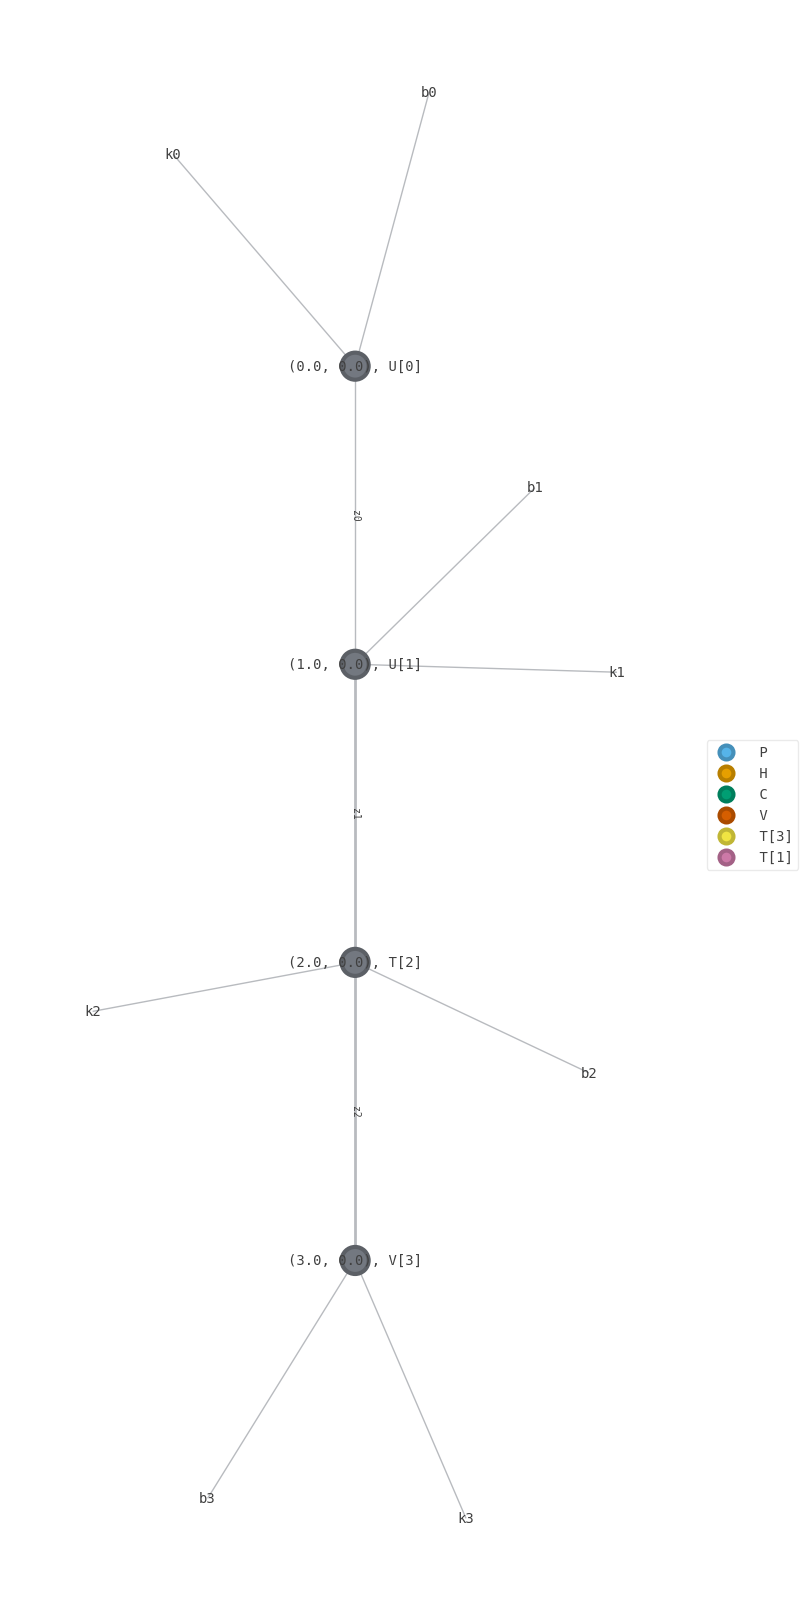

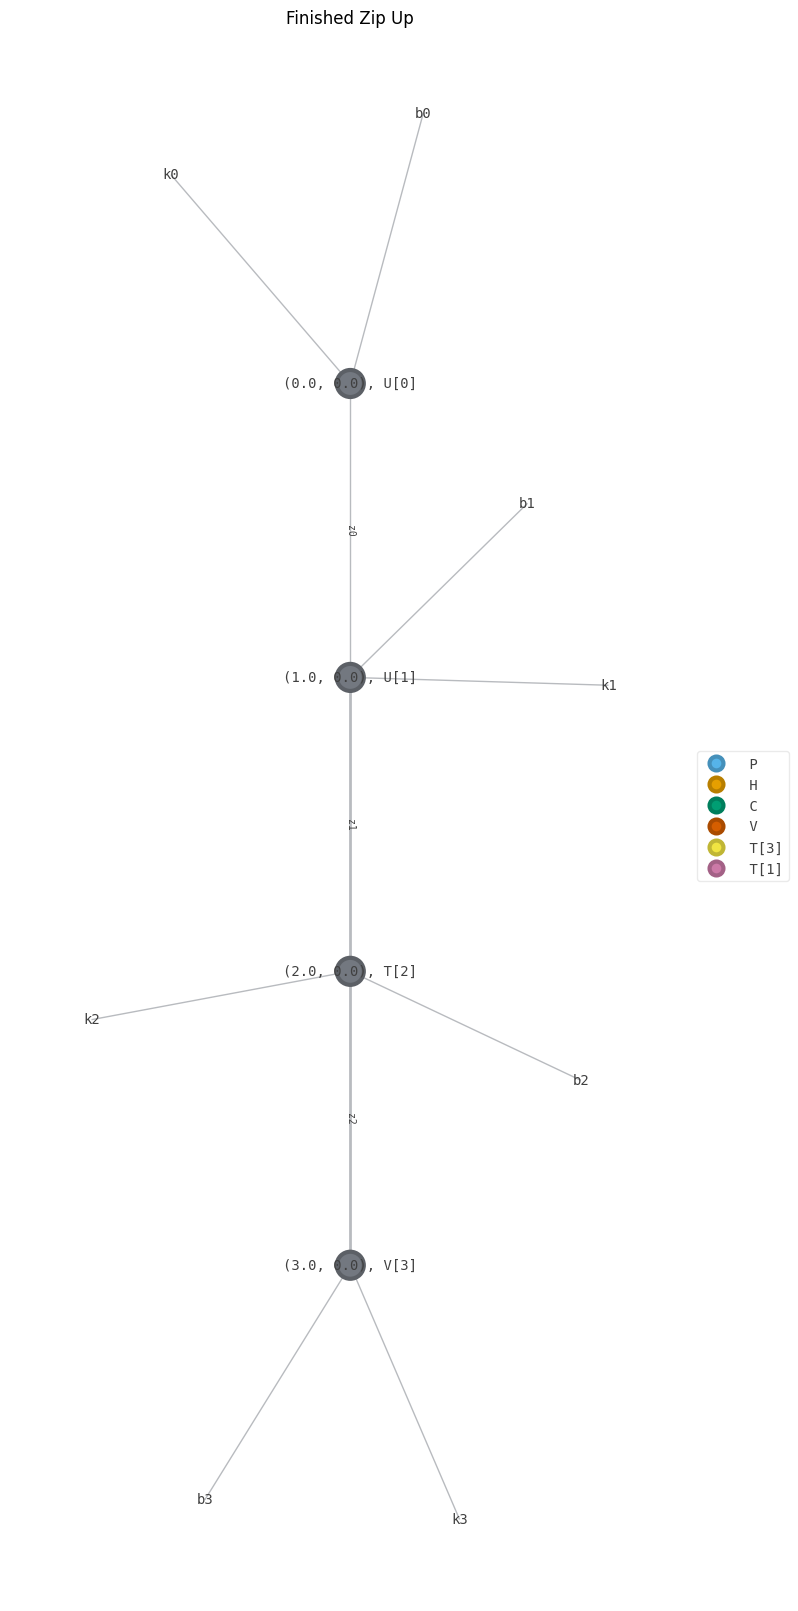

Tensor shape: (2, 2, 2)
Tensor: Tensor(shape=(2, 2, 2), inds=('b0', 'k0', 'z0'), tags=oset(['(0.0, 0.0)', 'U[0]']), backend='numpy', dtype='complex128')
Tensor Data:
 [[[ 0.70710678+0.j  0.        +0.j]
  [ 0.70710678+0.j  0.        +0.j]]

 [[ 0.        +0.j  0.70710678+0.j]
  [ 0.        +0.j -0.70710678+0.j]]]

Tensor shape: (2, 2, 2, 4)
Tensor: Tensor(shape=(2, 2, 2, 4), inds=('b1', 'k1', 'z0', 'z1'), tags=oset(['(1.0, 0.0)', 'U[1]']), backend='numpy', dtype='complex128')
Tensor Data:
 [[[[-2.22044605e-16-1.47424196e-17j  2.48908529e-17-5.00000000e-01j
     1.40897403e-01-4.12784385e-01j  8.95599657e-02+2.27455459e-01j]
   [ 5.72072628e-17-1.86572718e-17j -2.77785117e-01-4.15734806e-01j
     1.12178808e-01+4.21496076e-01j -2.00833873e-01-1.39365452e-01j]]

  [[-1.95443151e-16-1.47424196e-17j  3.03198938e-17-5.00000000e-01j
     1.40897403e-01-4.12784385e-01j  8.95599657e-02+2.27455459e-01j]
   [-1.86572718e-17-5.72072628e-17j -4.15734806e-01+2.77785117e-01j
     4.21496076e-01-1.12

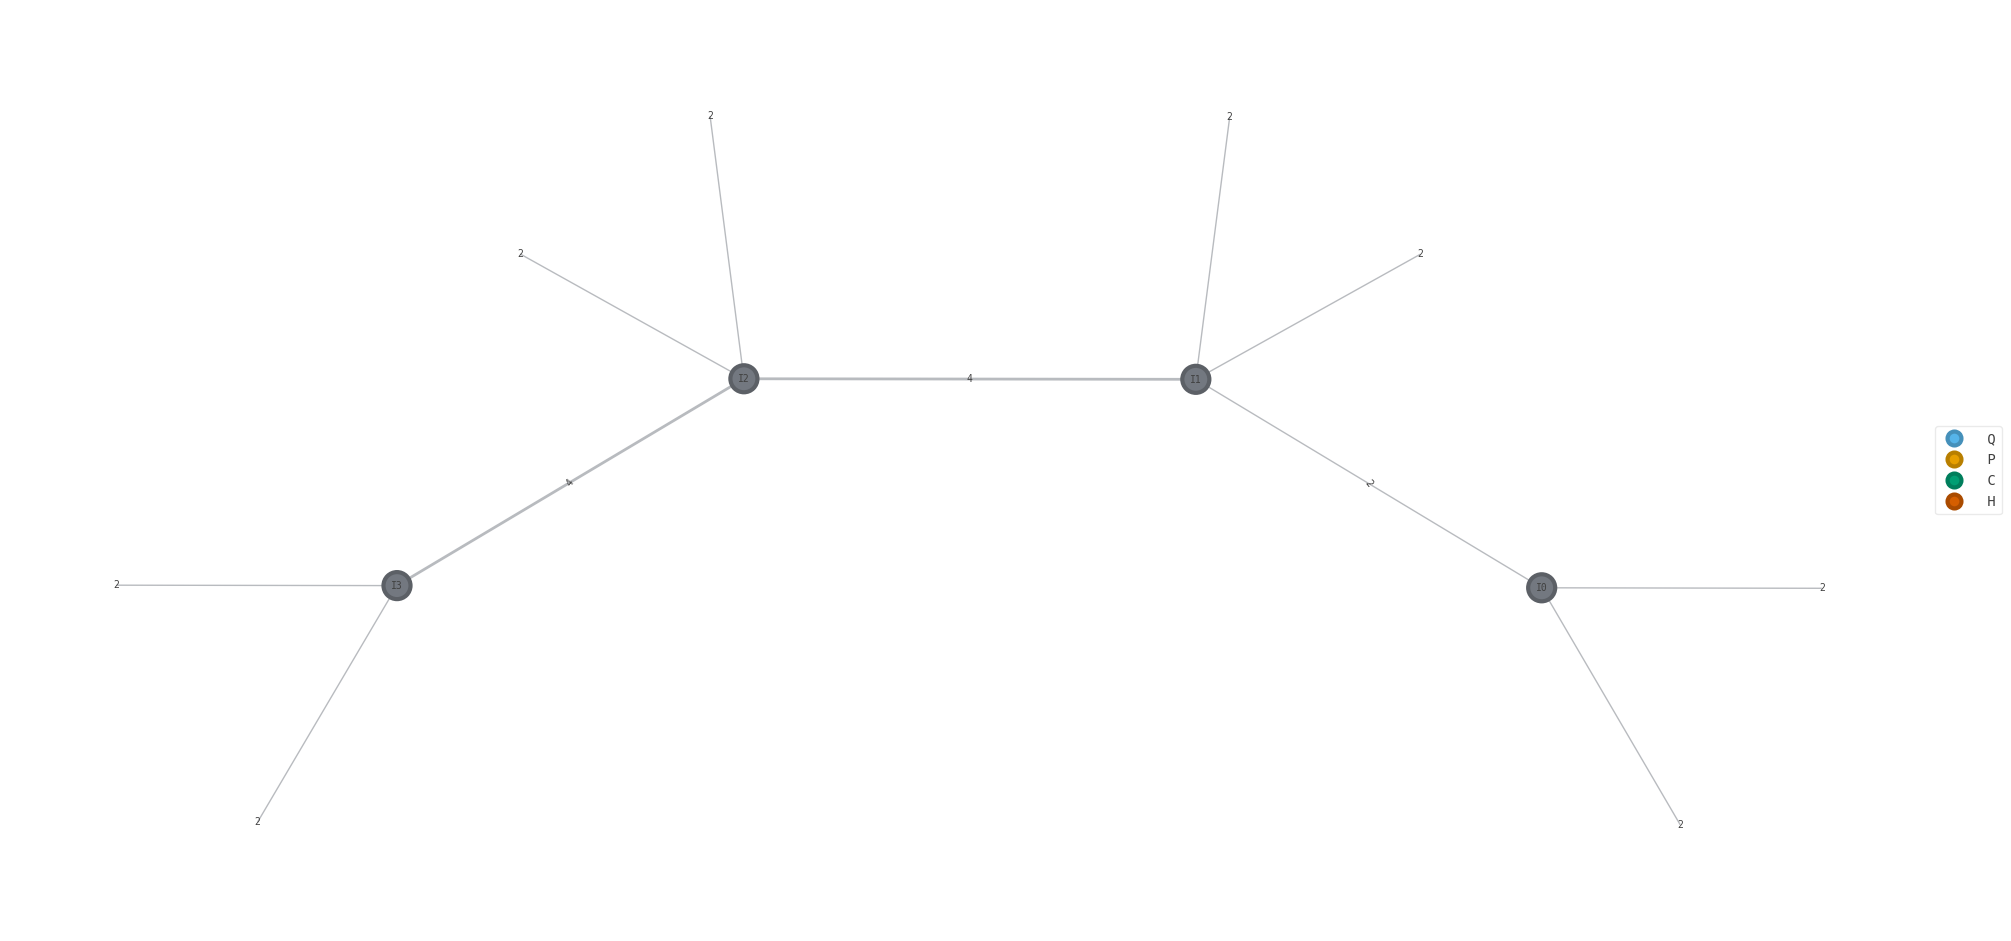

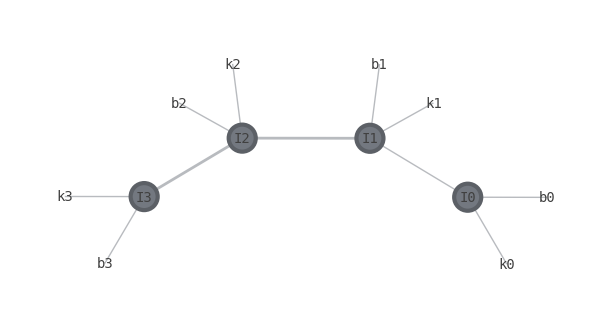

In [2]:
QFT_MPO = QFT(4)
QFT_MPO.create_circuit()
QFT_MPO.draw()
mpo = QFT_MPO.create_MPO(max_bond_dim=-1, cutoff=1e-15, verbose=True)

mpo.draw()

# Comparing MPS

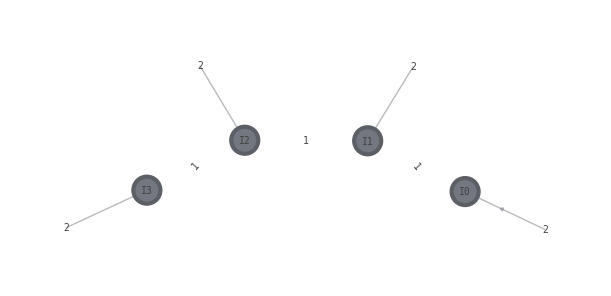

(2, 1)
[[-0.65328148+0.27059805j]
 [ 0.65328148-0.27059805j]]

(1, 2, 1)
[[[7.07106781e-01+0.j        ]
  [1.11022302e-16-0.70710678j]]]

(1, 2, 1)
[[[0.70710678+0.j ]
  [0.5       -0.5j]]]

(1, 2)
[[-1.41421356+0.j        -1.30656296+0.5411961j]]



In [23]:
QFT_mps = MPS(4)


mps = QFT_mps.create_MPS(
    [lambda x: np.exp(2j*np.pi*x)/2], 
    0, 
    1.0, 
    max_bond=4,
    cutoff=1e-15
)

mps.draw(show_inds='bond-size')
for t in mps.tensors_sorted():
    print(t.shape)
    print(t.data, end='\n\n')

In [24]:
python_mps_res = mps.to_dense().reshape((16,))
print(python_mps_res.shape)
print(python_mps_res)

(16,)
[ 4.61939766e-01-1.91341716e-01j  3.53553391e-01-3.53553391e-01j
  1.91341716e-01-4.61939766e-01j -1.38777878e-16-5.00000000e-01j
 -1.91341716e-01-4.61939766e-01j -3.53553391e-01-3.53553391e-01j
 -4.61939766e-01-1.91341716e-01j -5.00000000e-01+2.77555756e-17j
 -4.61939766e-01+1.91341716e-01j -3.53553391e-01+3.53553391e-01j
 -1.91341716e-01+4.61939766e-01j  2.77555756e-17+5.00000000e-01j
  1.91341716e-01+4.61939766e-01j  3.53553391e-01+3.53553391e-01j
  4.61939766e-01+1.91341716e-01j  5.00000000e-01+8.32667268e-17j]


In [25]:
julia_mps_res = np.array([0.4999999999999996 + 2.9314579421307735e-17j, 0.4619397662556433 + 0.19134171618254486j, 0.3535533905932737 + 0.3535533905932735j, 0.19134171618254503 + 0.46193976625564337j, -4.0491443498878406e-17 + 0.49999999999999944j, -0.1913417161825448 + 0.46193976625564315j, -0.3535533905932734 + 0.35355339059327356j, -0.46193976625564326 + 0.19134171618254495j, -0.49999999999999967 + 6.568865448039731e-17j, -0.46193976625564337 - 0.1913417161825448j, -0.3535533905932738 - 0.3535533905932735j, -0.19134171618254514 - 0.4619397662556434j, -5.451179040282661e-17 - 0.4999999999999995j, 0.19134171618254475 - 0.4619397662556432j, 0.3535533905932734 - 0.3535533905932737j, 0.46193976625564326 - 0.19134171618254509j])

julia_mps_res = julia_mps_res[::-1].reshape((16,))
print(julia_mps_res.shape)
print(julia_mps_res)

(16,)
[ 4.61939766e-01-1.91341716e-01j  3.53553391e-01-3.53553391e-01j
  1.91341716e-01-4.61939766e-01j -5.45117904e-17-5.00000000e-01j
 -1.91341716e-01-4.61939766e-01j -3.53553391e-01-3.53553391e-01j
 -4.61939766e-01-1.91341716e-01j -5.00000000e-01+6.56886545e-17j
 -4.61939766e-01+1.91341716e-01j -3.53553391e-01+3.53553391e-01j
 -1.91341716e-01+4.61939766e-01j -4.04914435e-17+5.00000000e-01j
  1.91341716e-01+4.61939766e-01j  3.53553391e-01+3.53553391e-01j
  4.61939766e-01+1.91341716e-01j  5.00000000e-01+2.93145794e-17j]


## Comparing norms of both

In [26]:
np.linalg.norm(julia_mps_res - python_mps_res)

6.660815486770961e-16

In [27]:
res = mps.contract()
print(res.data)

[[[[ 4.61939766e-01-1.91341716e-01j  3.53553391e-01-3.53553391e-01j]
   [ 1.91341716e-01-4.61939766e-01j -1.38777878e-16-5.00000000e-01j]]

  [[-1.91341716e-01-4.61939766e-01j -3.53553391e-01-3.53553391e-01j]
   [-4.61939766e-01-1.91341716e-01j -5.00000000e-01+2.77555756e-17j]]]


 [[[-4.61939766e-01+1.91341716e-01j -3.53553391e-01+3.53553391e-01j]
   [-1.91341716e-01+4.61939766e-01j  2.77555756e-17+5.00000000e-01j]]

  [[ 1.91341716e-01+4.61939766e-01j  3.53553391e-01+3.53553391e-01j]
   [ 4.61939766e-01+1.91341716e-01j  5.00000000e-01+8.32667268e-17j]]]]


# Comparing MPS applied to MPO

## MPO applied to MPS

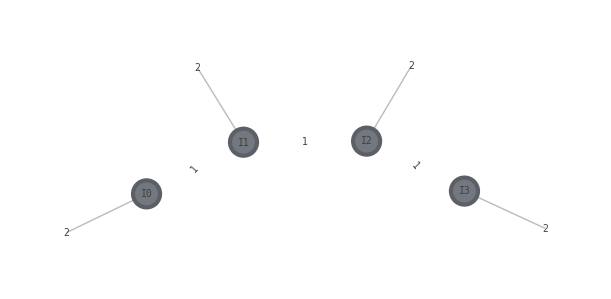

In [28]:
mpo_mps_res = mpo.apply(mps, compress=True)
mpo_mps_res.draw(show_inds='bond-size')

In [29]:
for t in mpo_mps_res.tensors:
    print(t.shape)
    print(t.data, end='\n\n')

(1, 2)
[[-2.49424921e-16-1.69150234e-16j  2.38903018e+00+1.05875489e+00j]]

(1, 1, 2)
[[[-1.93614197e-16+0.j         -7.36340267e-01+0.67661142j]]]

(1, 1, 2)
[[[ 3.39810365e-16+0.j         -9.47334662e-01-0.32024528j]]]

(1, 2)
[[-0.70710678+0.00000000e+00j  0.70710678+3.39891166e-16j]]



## Comparing MPS applied to MPO results

In [30]:
python_mpo_mps_res = mpo_mps_res.to_dense().reshape(16,)[::-1]
print(python_mpo_mps_res)

[ 1.84775907e+00+7.77156117e-16j -1.84775907e+00+2.22044605e-16j
 -5.94819765e-16+2.01078066e-16j  5.94819765e-16-2.01078066e-16j
  2.63427489e-16+2.42059351e-16j -2.63427489e-16-2.42059351e-16j
 -1.11142577e-31-4.92554457e-32j  1.11142577e-31+4.92554457e-32j
 -2.09705994e-16-3.78905351e-17j  2.09705994e-16+3.78905351e-17j
  7.16306731e-32-1.06232662e-32j -7.16306731e-32+1.06232662e-32j
 -2.49332102e-32-3.28737152e-32j  2.49332102e-32+3.28737152e-32j
  1.16037581e-47+7.86921529e-48j -1.16037581e-47-7.86921529e-48j]


In [31]:
array_to_latex(python_mpo_mps_res, precision=10, max_size=16)

<IPython.core.display.Latex object>

In [12]:
julia_mpo_mps_res = np.array([-1.4125382779160973e-16 - 2.148364964292212e-16j, 1.9999999999999956 + 6.106226635438361e-16j, -3.7655715704724443e-32 + 7.677085248059193e-33j, 1.1102230246251593e-16 - 2.7755575615628953e-16j, 3.0373981422218387e-32 - 1.2672912130365601e-31j, 6.938893903907234e-16 + 7.389922007661208e-16j, -1.5901103869005045e-47 - 1.1250116108652164e-47j, 1.4107436842636575e-31 - 5.527418940391389e-32j, 2.817377962344099e-32 + 2.3769603812314797e-31j, -1.6653345369377384e-15 - 8.326672684688697e-16j, 3.4550910739745326e-47 + 9.284883365742523e-48j, -2.080004339938228e-31 + 1.848892746611757e-31j, -7.805301577905057e-47 + 9.287748119969403e-47j, -2.70111674700311e-31 - 9.042241088898125e-31j, 8.556526999169706e-63 + 1.5987767812271156e-62j, -1.404805131624471e-46 - 1.2708996196488563e-47j])
array_to_latex(julia_mpo_mps_res, precision=10, max_size=16)

<IPython.core.display.Latex object>

In [13]:
np.linalg.norm(python_mpo_mps_res - julia_mpo_mps_res)

4.2684263358802905